In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
# It transforms image pixel value to range -1 to +1
transforms=torchvision.transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])

In [0]:
train_set=torchvision.datasets.MNIST('MNIST',train=True,download=True,transform=transforms)
test_set=torchvision.datasets.MNIST('MNIST',train=False,download=True,transform=transforms)

In [0]:
train_gen=torch.utils.data.DataLoader(train_set,batch_size=128,num_workers=2,shuffle=True)
test_gen=torch.utils.data.DataLoader(test_set,batch_size=128,num_workers=2,shuffle=True)

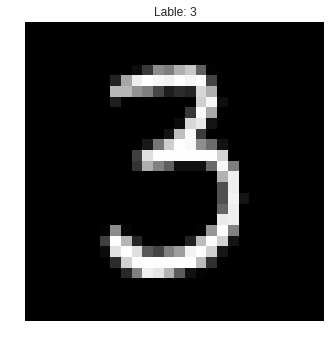

In [6]:
#Check some images
from matplotlib import pyplot as plt
N=50
plt.imshow(train_set[N][0].view(28,28)/2+0.5,cmap='gray') #Convert image pixel values in range 0 to 1 and then plot image.
plt.title("Lable: "+str(train_set[N][1].item()))
plt.axis('off')
plt.show()

In [0]:
#Discriminator Network
class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,1024)
        self.fc2=nn.Linear(1024,512)
        self.fc3=nn.Linear(512,1)
    def forward(self,x):
        x=x.view(-1,28*28) #Convert 2d image to 1d vector
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))
        return x

In [8]:
Dis=D()
#Move network to cuda if available
Dis.to(device)

D(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

In [0]:
#Generator Network
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(100,512)
        self.fc2=nn.Linear(512,1024)
        self.fc3=nn.Linear(1024,28*28)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=torch.tanh(self.fc3(x))
        x=x.view(-1,28,28) # Convert 1d vector to 2d image representation
        return x

In [10]:
Gen=G()
#Move network to cuda if available
Gen.to(device)

G(
  (fc1): Linear(in_features=100, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=784, bias=True)
)

In [0]:
#Define optimizer
D_optim=torch.optim.Adam(Dis.parameters(),lr=0.0001)
G_optim=torch.optim.Adam(Gen.parameters(),lr=0.0001)
#Define loss function
loss_fn=nn.BCELoss()

In [0]:
#Function to train Discriminator
def train_D(real_image):
    D_optim.zero_grad() #Clear gradient buffer
    real_output=Dis(real_image)
    real_loss=loss_fn(real_output,torch.ones_like(real_output))
    fake_image=Gen(torch.randn(real_image.shape[0],100,device=device)).detach() #Generate fake images and detach it so that gradient is not computed in Generator network
    fake_output=Dis(fake_image)
    fake_loss=loss_fn(fake_output,torch.zeros_like(fake_output))
    dis_loss=real_loss+fake_loss
    dis_loss.backward() 
    D_optim.step()
    return dis_loss

In [0]:
#Function to train Generator
def train_G(batch_size):
    G_optim.zero_grad() #Clear gradient buffer
    fake_images=Gen(torch.randn(batch_size,100,device=device)) #Generate fake images
    dis_output=Dis(fake_images) #Calculate Discriminators outputs
    gen_loss=loss_fn(dis_output,torch.ones_like(dis_output)) # Calculate loss by giving fake image label 1(assuming as real) 
    gen_loss.backward()
    G_optim.step()
    return gen_loss

In [0]:
#For checking traning progess
def inspect(N=4):
    with torch.no_grad():
        images=Gen(torch.randn(N*N,100,device=device)).to('cpu') #Generates Images
    figure,axis = plt.subplots(N, N) 
    figure.set_figheight(7)
    figure.set_figwidth(7)
    for i in range(N):
        for j in range(N):
            axis[i,j].imshow(images[i*N+j].view(28,28)/2+0.5,cmap='gray') #Convert image pixel values in range 0 to 1 and then plot image.
            axis[i,j].set_xticklabels([])
            axis[i,j].set_yticklabels([])
            axis[i,j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [0]:
#Function to train GAN
def train_gan(epochs):
    inspect()
    for e in range(epochs):
        print("----------------------Epoch Number:{}------------------------".format(e+1))
        for i,data in enumerate(train_gen,1):
            X,_=data
            X=X.to(device)
            dis_loss=train_D(X)
            gen_loss=train_G(X.shape[0])
            if i%100==0:
                print("Discriminator Loss: ",dis_loss.item(),"Generator Loss: ",gen_loss.item()) 
        inspect()

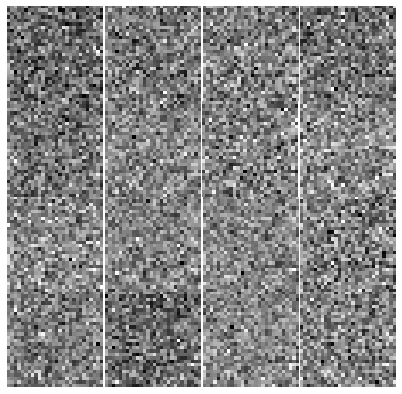

----------------------Epoch Number:1------------------------
Discriminator Loss:  0.13702954351902008 Generator Loss:  2.944854259490967
Discriminator Loss:  0.07727832347154617 Generator Loss:  3.6599738597869873
Discriminator Loss:  0.08295126259326935 Generator Loss:  5.648615837097168
Discriminator Loss:  0.06207262724637985 Generator Loss:  5.1939311027526855


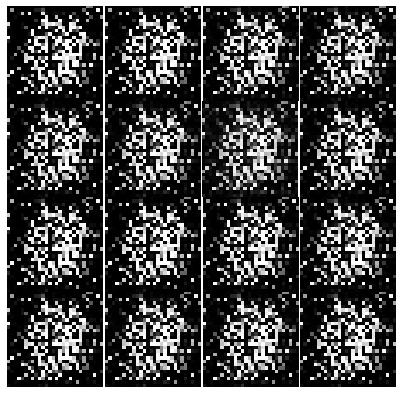

----------------------Epoch Number:2------------------------
Discriminator Loss:  0.021422920748591423 Generator Loss:  5.657388210296631
Discriminator Loss:  0.042409852147102356 Generator Loss:  6.153601169586182
Discriminator Loss:  0.01896643452346325 Generator Loss:  7.406691074371338
Discriminator Loss:  0.04639642685651779 Generator Loss:  5.657790660858154


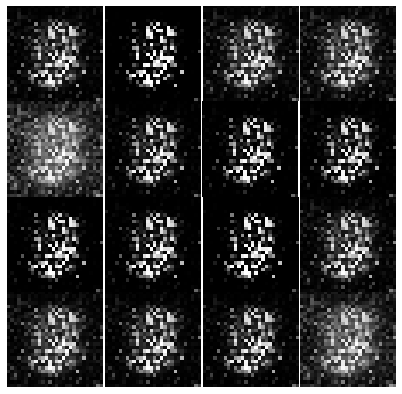

----------------------Epoch Number:3------------------------
Discriminator Loss:  0.8166922926902771 Generator Loss:  4.512514591217041
Discriminator Loss:  0.3959035277366638 Generator Loss:  3.297832489013672
Discriminator Loss:  0.18492642045021057 Generator Loss:  3.5762224197387695
Discriminator Loss:  0.4345954656600952 Generator Loss:  2.3158607482910156


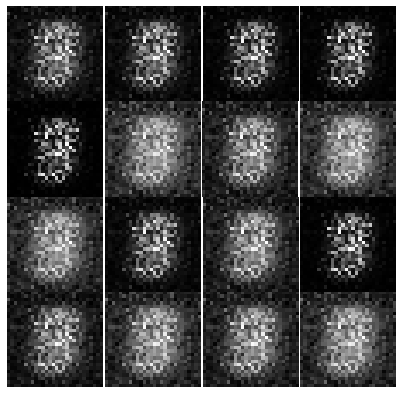

----------------------Epoch Number:4------------------------
Discriminator Loss:  0.1516614407300949 Generator Loss:  3.480665445327759
Discriminator Loss:  0.14032824337482452 Generator Loss:  3.6011056900024414
Discriminator Loss:  0.055084843188524246 Generator Loss:  4.140323162078857
Discriminator Loss:  0.040671393275260925 Generator Loss:  4.697826862335205


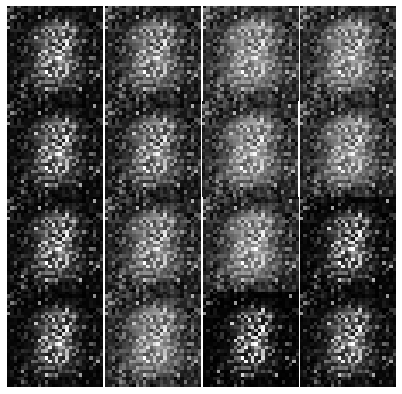

----------------------Epoch Number:5------------------------
Discriminator Loss:  0.07541757076978683 Generator Loss:  5.124835014343262
Discriminator Loss:  0.11175188422203064 Generator Loss:  3.8613362312316895
Discriminator Loss:  0.10336574912071228 Generator Loss:  4.223880290985107
Discriminator Loss:  0.048796750605106354 Generator Loss:  5.790821075439453


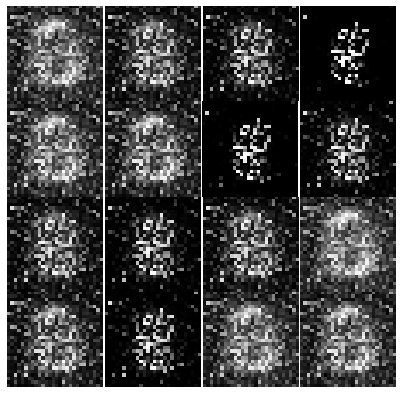

----------------------Epoch Number:6------------------------
Discriminator Loss:  0.14112630486488342 Generator Loss:  5.376867771148682
Discriminator Loss:  0.033521100878715515 Generator Loss:  5.590773105621338
Discriminator Loss:  0.03875359892845154 Generator Loss:  5.736459732055664
Discriminator Loss:  0.029575536027550697 Generator Loss:  5.627763748168945


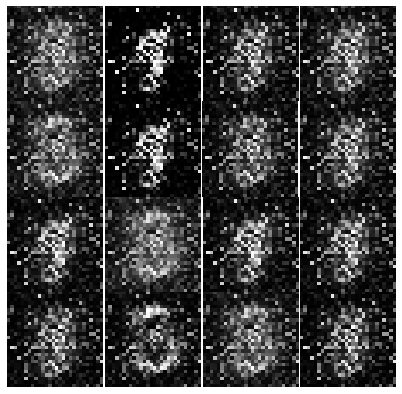

----------------------Epoch Number:7------------------------
Discriminator Loss:  0.04165402799844742 Generator Loss:  7.112344264984131
Discriminator Loss:  0.01367185264825821 Generator Loss:  6.125810146331787
Discriminator Loss:  0.03857586532831192 Generator Loss:  5.425731658935547
Discriminator Loss:  0.03926596790552139 Generator Loss:  5.394312858581543


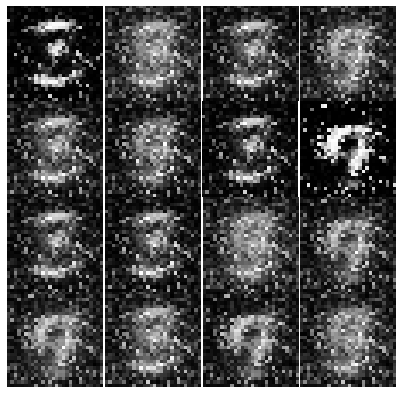

----------------------Epoch Number:8------------------------
Discriminator Loss:  0.04439854621887207 Generator Loss:  6.372560501098633
Discriminator Loss:  0.03316238522529602 Generator Loss:  7.464596748352051
Discriminator Loss:  0.027242444455623627 Generator Loss:  9.495798110961914
Discriminator Loss:  0.04613081365823746 Generator Loss:  5.8686394691467285


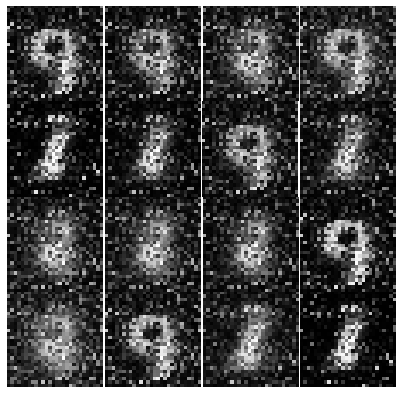

----------------------Epoch Number:9------------------------
Discriminator Loss:  0.026834595948457718 Generator Loss:  6.514688014984131
Discriminator Loss:  0.0594865120947361 Generator Loss:  5.6271653175354
Discriminator Loss:  0.02849859930574894 Generator Loss:  6.336324691772461
Discriminator Loss:  0.042677849531173706 Generator Loss:  7.22441291809082


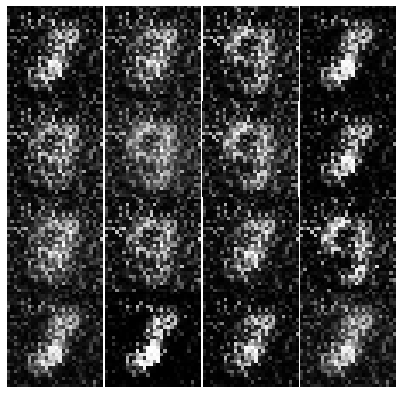

----------------------Epoch Number:10------------------------
Discriminator Loss:  0.003052767366170883 Generator Loss:  7.759372711181641
Discriminator Loss:  0.011983054690063 Generator Loss:  6.344036102294922
Discriminator Loss:  0.023447345942258835 Generator Loss:  6.683981895446777
Discriminator Loss:  0.04456593096256256 Generator Loss:  6.436781883239746


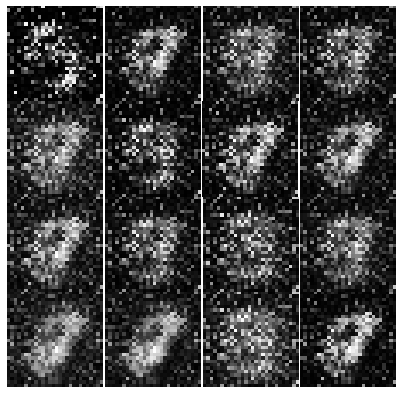

----------------------Epoch Number:11------------------------
Discriminator Loss:  0.04481735825538635 Generator Loss:  9.684209823608398
Discriminator Loss:  0.04484309256076813 Generator Loss:  7.240272521972656
Discriminator Loss:  0.06733065098524094 Generator Loss:  7.606287479400635
Discriminator Loss:  0.15565693378448486 Generator Loss:  7.5913848876953125


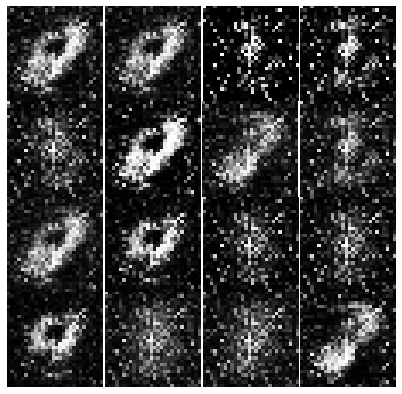

----------------------Epoch Number:12------------------------
Discriminator Loss:  0.012520747259259224 Generator Loss:  7.963689804077148
Discriminator Loss:  0.03164057433605194 Generator Loss:  5.512532711029053
Discriminator Loss:  0.012513085268437862 Generator Loss:  8.331377983093262
Discriminator Loss:  0.07248054444789886 Generator Loss:  7.764242172241211


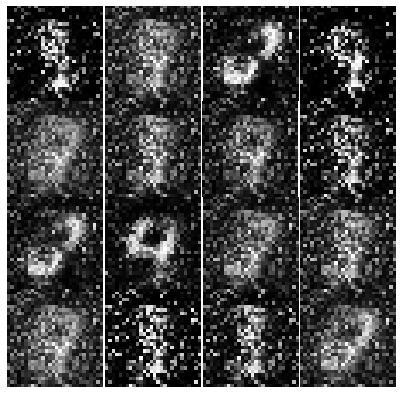

----------------------Epoch Number:13------------------------
Discriminator Loss:  0.05966462939977646 Generator Loss:  6.407835483551025
Discriminator Loss:  0.21220992505550385 Generator Loss:  7.247296333312988
Discriminator Loss:  0.026612697169184685 Generator Loss:  9.533473014831543
Discriminator Loss:  0.043712977319955826 Generator Loss:  10.143768310546875


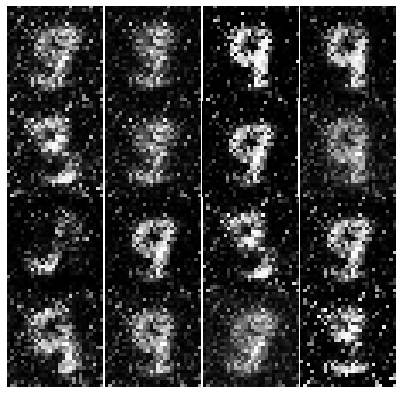

----------------------Epoch Number:14------------------------
Discriminator Loss:  0.05714008957147598 Generator Loss:  6.495969772338867
Discriminator Loss:  0.013961195945739746 Generator Loss:  10.46554946899414
Discriminator Loss:  0.037564001977443695 Generator Loss:  6.064150810241699
Discriminator Loss:  0.10816232860088348 Generator Loss:  6.058390140533447


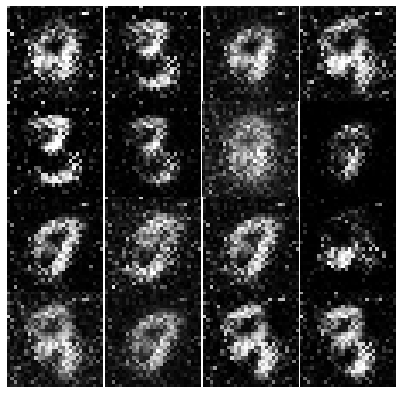

----------------------Epoch Number:15------------------------
Discriminator Loss:  0.03621887043118477 Generator Loss:  7.20216178894043
Discriminator Loss:  0.19075623154640198 Generator Loss:  8.387850761413574
Discriminator Loss:  0.0788077712059021 Generator Loss:  7.061006546020508
Discriminator Loss:  0.11172710359096527 Generator Loss:  4.979416370391846


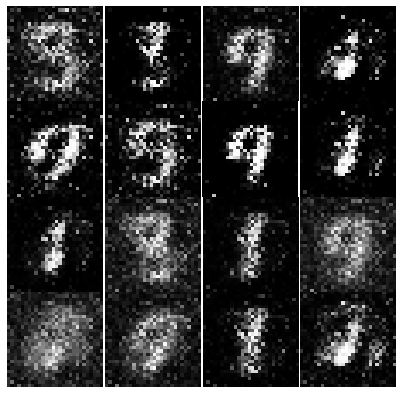

----------------------Epoch Number:16------------------------
Discriminator Loss:  0.16953545808792114 Generator Loss:  4.833620071411133
Discriminator Loss:  0.13262630999088287 Generator Loss:  6.684577941894531
Discriminator Loss:  0.12634024024009705 Generator Loss:  6.148186206817627
Discriminator Loss:  0.43477100133895874 Generator Loss:  6.4328694343566895


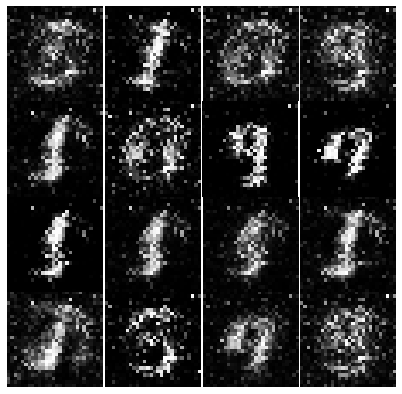

----------------------Epoch Number:17------------------------
Discriminator Loss:  0.07614278048276901 Generator Loss:  6.045733451843262
Discriminator Loss:  0.09297586232423782 Generator Loss:  9.081457138061523
Discriminator Loss:  0.1047920361161232 Generator Loss:  6.559548854827881
Discriminator Loss:  0.06763539463281631 Generator Loss:  5.9011383056640625


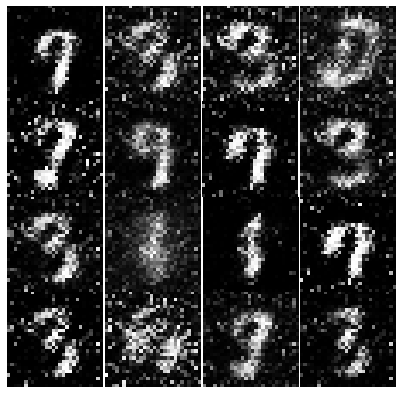

----------------------Epoch Number:18------------------------
Discriminator Loss:  0.16407103836536407 Generator Loss:  8.223118782043457
Discriminator Loss:  0.101978600025177 Generator Loss:  9.391805648803711
Discriminator Loss:  0.06699081510305405 Generator Loss:  4.585644721984863
Discriminator Loss:  0.1030871793627739 Generator Loss:  6.3891119956970215


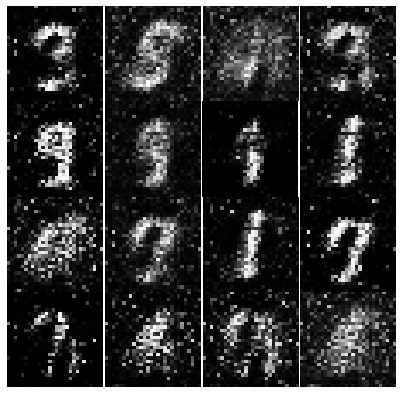

----------------------Epoch Number:19------------------------
Discriminator Loss:  0.11107078194618225 Generator Loss:  4.182551383972168
Discriminator Loss:  0.2892371416091919 Generator Loss:  5.4766740798950195
Discriminator Loss:  0.1193787232041359 Generator Loss:  6.109194755554199
Discriminator Loss:  0.13338954746723175 Generator Loss:  5.854055404663086


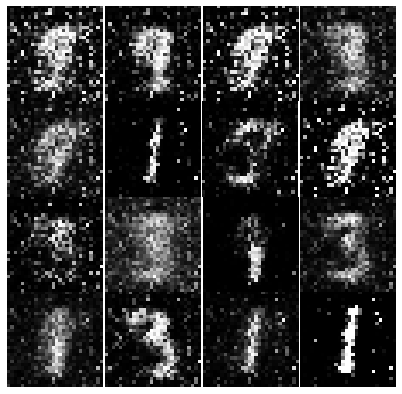

----------------------Epoch Number:20------------------------
Discriminator Loss:  0.15611618757247925 Generator Loss:  7.8316144943237305
Discriminator Loss:  0.05003632605075836 Generator Loss:  7.273162841796875
Discriminator Loss:  0.1305023729801178 Generator Loss:  4.9481201171875
Discriminator Loss:  0.11103810369968414 Generator Loss:  8.458106994628906


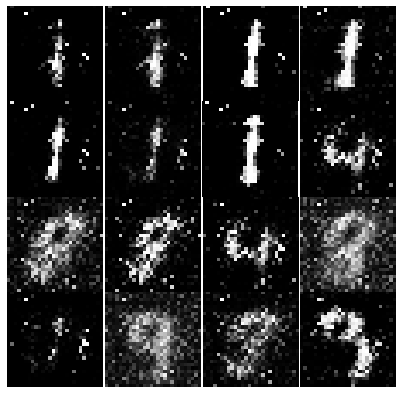

----------------------Epoch Number:21------------------------
Discriminator Loss:  0.07126404345035553 Generator Loss:  4.8899664878845215
Discriminator Loss:  0.11150453239679337 Generator Loss:  6.622541904449463
Discriminator Loss:  0.07958698272705078 Generator Loss:  5.2532196044921875
Discriminator Loss:  0.19479796290397644 Generator Loss:  4.671108245849609


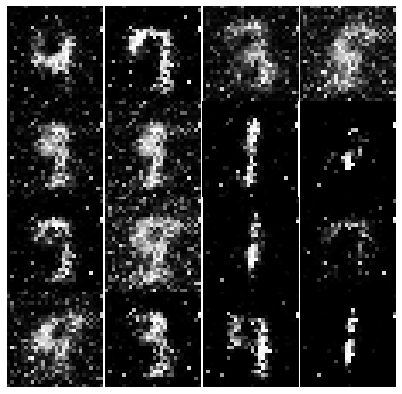

----------------------Epoch Number:22------------------------
Discriminator Loss:  0.10666912794113159 Generator Loss:  6.330333709716797
Discriminator Loss:  0.1443876028060913 Generator Loss:  5.477163314819336
Discriminator Loss:  0.14542655646800995 Generator Loss:  6.212414741516113
Discriminator Loss:  0.12370820343494415 Generator Loss:  4.443195343017578


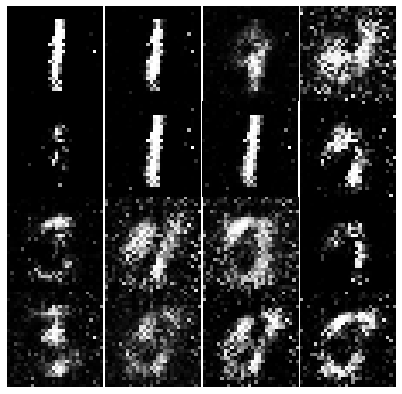

----------------------Epoch Number:23------------------------
Discriminator Loss:  0.20822392404079437 Generator Loss:  5.99542236328125
Discriminator Loss:  0.13675853610038757 Generator Loss:  5.967061996459961
Discriminator Loss:  0.11179398000240326 Generator Loss:  5.648769378662109
Discriminator Loss:  0.1392047107219696 Generator Loss:  6.072084903717041


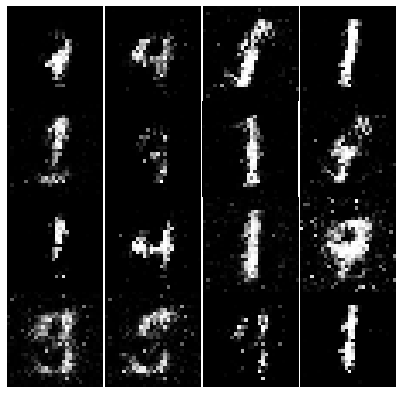

----------------------Epoch Number:24------------------------
Discriminator Loss:  0.13202418386936188 Generator Loss:  4.855587959289551
Discriminator Loss:  0.1679404228925705 Generator Loss:  5.0268707275390625
Discriminator Loss:  0.22358092665672302 Generator Loss:  3.3718342781066895
Discriminator Loss:  0.10750013589859009 Generator Loss:  6.072154998779297


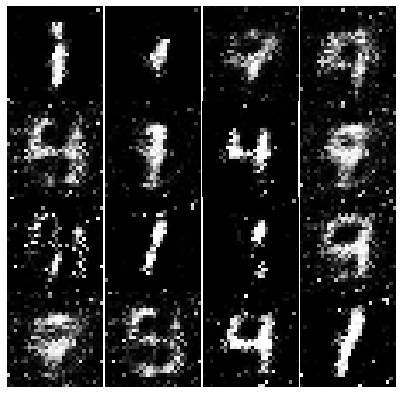

----------------------Epoch Number:25------------------------
Discriminator Loss:  0.18824169039726257 Generator Loss:  3.7099292278289795
Discriminator Loss:  0.2760443687438965 Generator Loss:  6.881739616394043
Discriminator Loss:  0.0749986320734024 Generator Loss:  7.353762626647949
Discriminator Loss:  0.11913737654685974 Generator Loss:  3.838057041168213


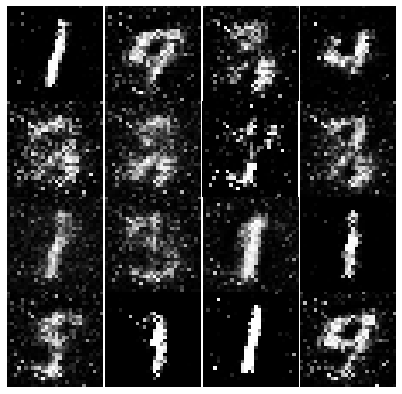

----------------------Epoch Number:26------------------------
Discriminator Loss:  0.1760510802268982 Generator Loss:  5.733776092529297
Discriminator Loss:  0.14549608528614044 Generator Loss:  6.113723278045654
Discriminator Loss:  0.2360920011997223 Generator Loss:  4.725057125091553
Discriminator Loss:  0.21831604838371277 Generator Loss:  2.910062789916992


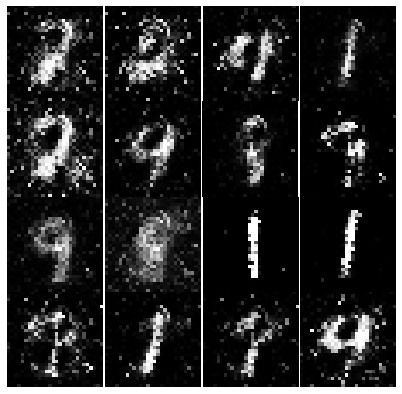

----------------------Epoch Number:27------------------------
Discriminator Loss:  0.19498783349990845 Generator Loss:  4.984814167022705
Discriminator Loss:  0.09631597995758057 Generator Loss:  6.60441780090332
Discriminator Loss:  0.14924737811088562 Generator Loss:  3.9387474060058594
Discriminator Loss:  0.21850571036338806 Generator Loss:  4.145224571228027


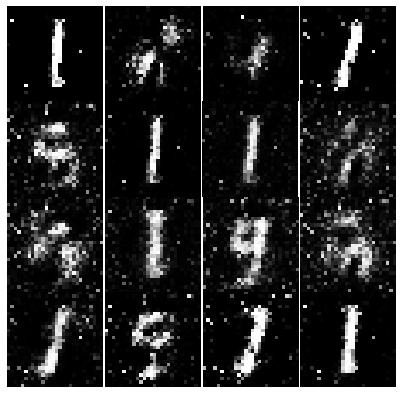

----------------------Epoch Number:28------------------------
Discriminator Loss:  0.3341677188873291 Generator Loss:  4.918771743774414
Discriminator Loss:  0.39142486453056335 Generator Loss:  3.4093072414398193
Discriminator Loss:  0.12966373562812805 Generator Loss:  4.486099720001221
Discriminator Loss:  0.1681751012802124 Generator Loss:  5.004073143005371


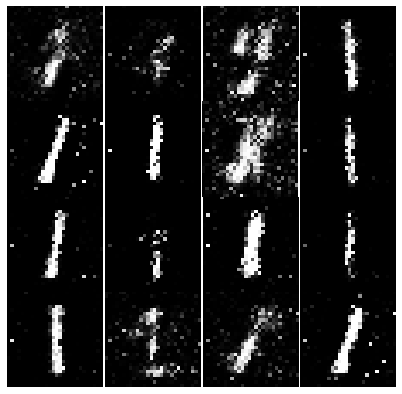

----------------------Epoch Number:29------------------------
Discriminator Loss:  0.3827444612979889 Generator Loss:  4.868414878845215
Discriminator Loss:  0.2830459475517273 Generator Loss:  5.120597839355469
Discriminator Loss:  0.20812562108039856 Generator Loss:  4.236962795257568
Discriminator Loss:  0.21202225983142853 Generator Loss:  4.127852916717529


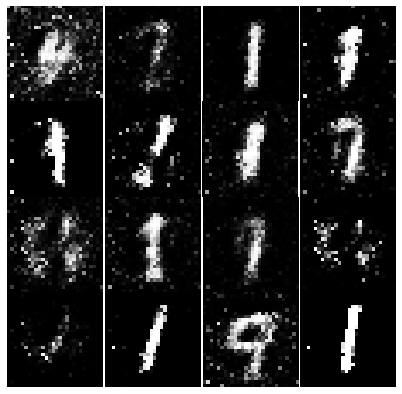

----------------------Epoch Number:30------------------------
Discriminator Loss:  0.30141890048980713 Generator Loss:  6.061834812164307
Discriminator Loss:  0.25893542170524597 Generator Loss:  5.694806098937988
Discriminator Loss:  0.13972029089927673 Generator Loss:  5.284920692443848
Discriminator Loss:  0.22592848539352417 Generator Loss:  4.289304733276367


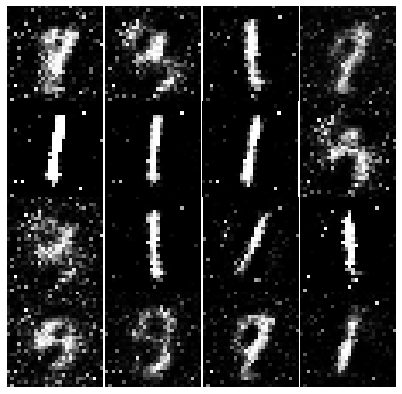

----------------------Epoch Number:31------------------------
Discriminator Loss:  0.34604117274284363 Generator Loss:  4.007951736450195
Discriminator Loss:  0.19876495003700256 Generator Loss:  3.195634603500366
Discriminator Loss:  0.2663823068141937 Generator Loss:  3.424675226211548
Discriminator Loss:  0.406762957572937 Generator Loss:  5.229480743408203


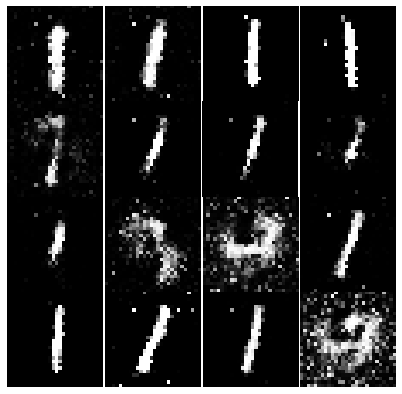

----------------------Epoch Number:32------------------------
Discriminator Loss:  0.3193618655204773 Generator Loss:  4.0959553718566895
Discriminator Loss:  0.27579551935195923 Generator Loss:  4.828121662139893
Discriminator Loss:  0.2499619424343109 Generator Loss:  2.962505578994751
Discriminator Loss:  0.3112923502922058 Generator Loss:  5.447410583496094


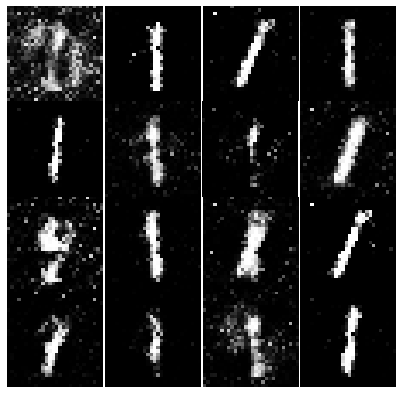

----------------------Epoch Number:33------------------------
Discriminator Loss:  0.22855447232723236 Generator Loss:  3.3783693313598633
Discriminator Loss:  0.18614253401756287 Generator Loss:  4.7505388259887695
Discriminator Loss:  0.2570817172527313 Generator Loss:  5.423734664916992
Discriminator Loss:  0.2678796052932739 Generator Loss:  4.341006278991699


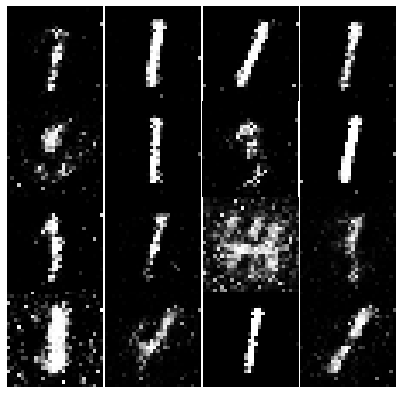

----------------------Epoch Number:34------------------------
Discriminator Loss:  0.17996050417423248 Generator Loss:  4.742974758148193
Discriminator Loss:  0.20696309208869934 Generator Loss:  3.968492031097412
Discriminator Loss:  0.341001033782959 Generator Loss:  4.814068794250488
Discriminator Loss:  0.26867273449897766 Generator Loss:  4.126187324523926


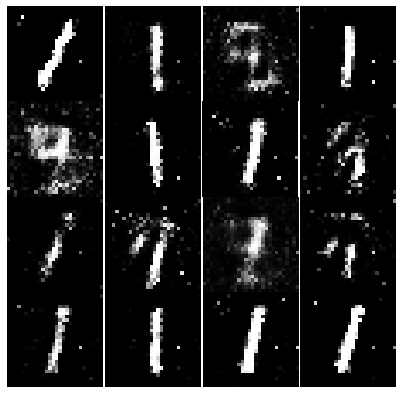

----------------------Epoch Number:35------------------------
Discriminator Loss:  0.3352077305316925 Generator Loss:  3.7355446815490723
Discriminator Loss:  0.1762315034866333 Generator Loss:  4.457882404327393
Discriminator Loss:  0.24855256080627441 Generator Loss:  4.103858947753906
Discriminator Loss:  0.257643461227417 Generator Loss:  5.077263832092285


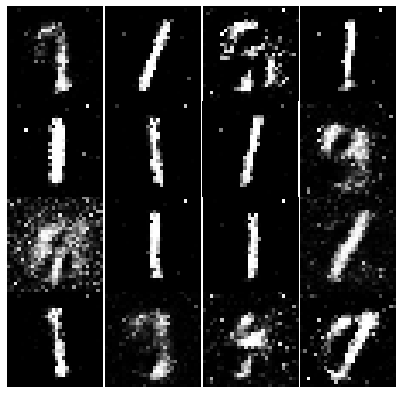

----------------------Epoch Number:36------------------------
Discriminator Loss:  0.28580379486083984 Generator Loss:  3.8324198722839355
Discriminator Loss:  0.2703324854373932 Generator Loss:  3.6302995681762695
Discriminator Loss:  0.26297175884246826 Generator Loss:  6.354030609130859
Discriminator Loss:  0.3591005206108093 Generator Loss:  3.8923189640045166


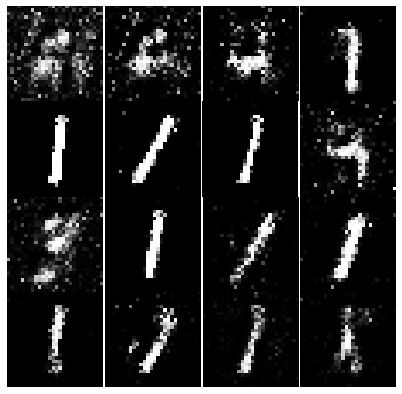

----------------------Epoch Number:37------------------------
Discriminator Loss:  0.4144718647003174 Generator Loss:  3.243661880493164
Discriminator Loss:  0.3439343571662903 Generator Loss:  4.180562973022461
Discriminator Loss:  0.34651339054107666 Generator Loss:  3.5320351123809814
Discriminator Loss:  0.3005189299583435 Generator Loss:  4.289828300476074


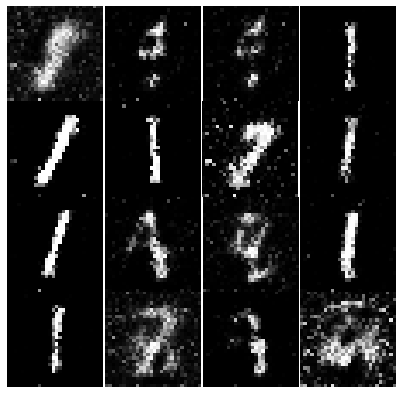

----------------------Epoch Number:38------------------------
Discriminator Loss:  0.4549582600593567 Generator Loss:  2.991457939147949
Discriminator Loss:  0.3819476366043091 Generator Loss:  4.186087131500244
Discriminator Loss:  0.33057525753974915 Generator Loss:  3.666645050048828
Discriminator Loss:  0.3875656723976135 Generator Loss:  4.216707706451416


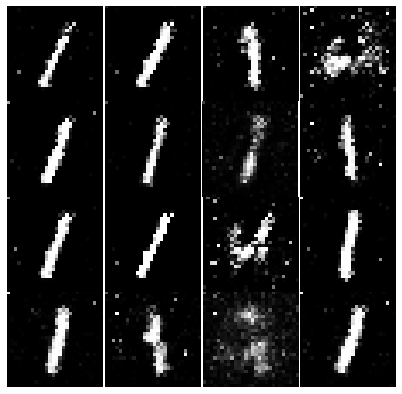

----------------------Epoch Number:39------------------------
Discriminator Loss:  0.21932318806648254 Generator Loss:  2.7196850776672363
Discriminator Loss:  0.33779218792915344 Generator Loss:  3.79565691947937
Discriminator Loss:  0.5675673484802246 Generator Loss:  3.233198404312134
Discriminator Loss:  0.5413475036621094 Generator Loss:  3.3784024715423584


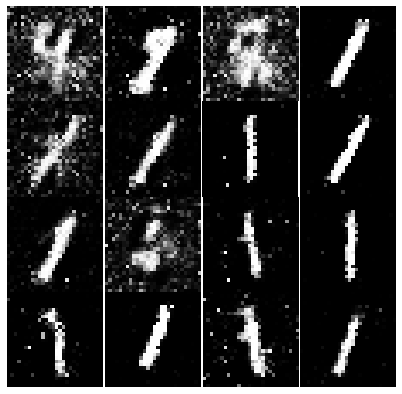

----------------------Epoch Number:40------------------------
Discriminator Loss:  0.609817385673523 Generator Loss:  3.416172504425049
Discriminator Loss:  0.41449522972106934 Generator Loss:  3.63120698928833
Discriminator Loss:  0.25536230206489563 Generator Loss:  2.9688615798950195
Discriminator Loss:  0.2964590787887573 Generator Loss:  4.658449172973633


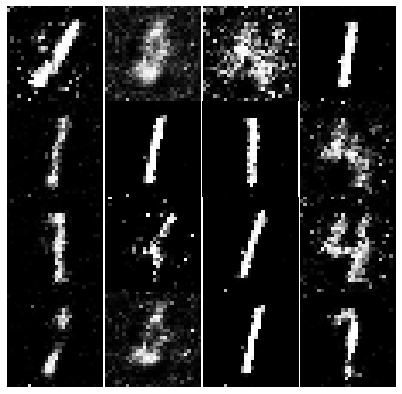

----------------------Epoch Number:41------------------------
Discriminator Loss:  0.26787129044532776 Generator Loss:  2.791581869125366
Discriminator Loss:  0.3474978804588318 Generator Loss:  3.491478443145752
Discriminator Loss:  0.20612592995166779 Generator Loss:  3.7907910346984863
Discriminator Loss:  0.42068198323249817 Generator Loss:  3.195417642593384


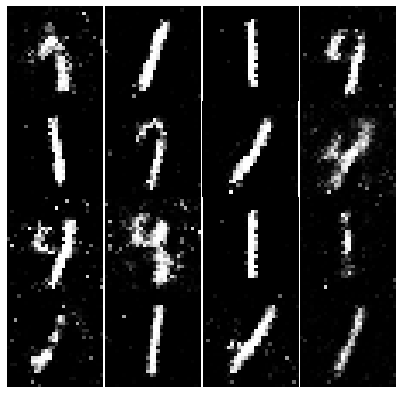

----------------------Epoch Number:42------------------------
Discriminator Loss:  0.3683067262172699 Generator Loss:  2.618802547454834
Discriminator Loss:  0.5010741949081421 Generator Loss:  2.3652398586273193
Discriminator Loss:  0.3327958285808563 Generator Loss:  2.5279431343078613
Discriminator Loss:  0.411317378282547 Generator Loss:  4.1159515380859375


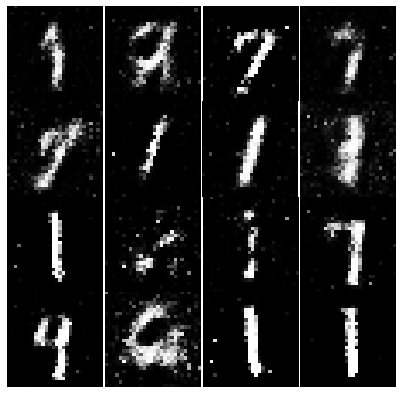

----------------------Epoch Number:43------------------------
Discriminator Loss:  0.4489753544330597 Generator Loss:  2.474818706512451
Discriminator Loss:  0.47327280044555664 Generator Loss:  3.3002638816833496
Discriminator Loss:  0.2772204875946045 Generator Loss:  3.1991753578186035
Discriminator Loss:  0.3100874423980713 Generator Loss:  3.1517772674560547


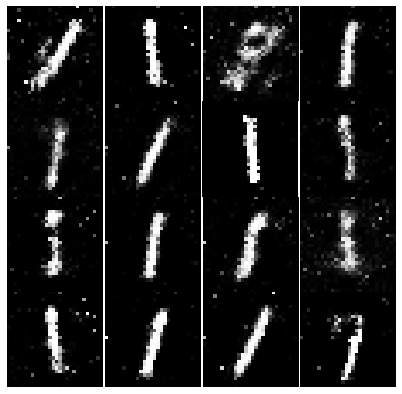

----------------------Epoch Number:44------------------------
Discriminator Loss:  0.2495030015707016 Generator Loss:  3.6825952529907227
Discriminator Loss:  0.3967704474925995 Generator Loss:  3.3105263710021973
Discriminator Loss:  0.3386152684688568 Generator Loss:  3.6201119422912598
Discriminator Loss:  0.3207135796546936 Generator Loss:  4.441601753234863


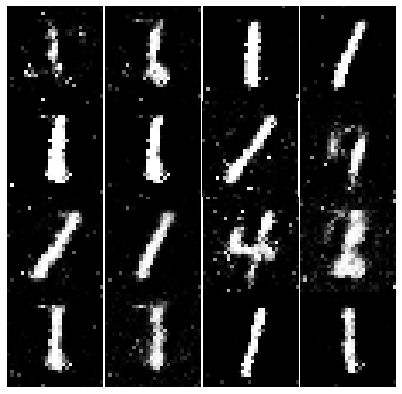

----------------------Epoch Number:45------------------------
Discriminator Loss:  0.7797002792358398 Generator Loss:  4.350002288818359
Discriminator Loss:  0.6718907952308655 Generator Loss:  3.1168770790100098
Discriminator Loss:  0.26551640033721924 Generator Loss:  3.4873547554016113
Discriminator Loss:  0.5035783052444458 Generator Loss:  3.450690507888794


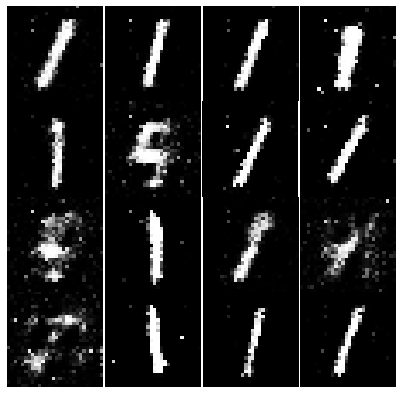

----------------------Epoch Number:46------------------------
Discriminator Loss:  0.38691824674606323 Generator Loss:  3.118907928466797
Discriminator Loss:  0.38887542486190796 Generator Loss:  2.253530502319336
Discriminator Loss:  0.2568403482437134 Generator Loss:  3.3931853771209717
Discriminator Loss:  0.23662109673023224 Generator Loss:  2.218588352203369


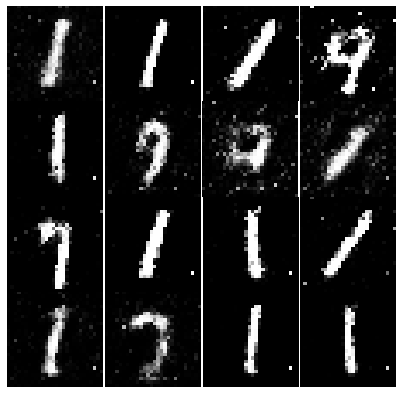

----------------------Epoch Number:47------------------------
Discriminator Loss:  0.43925344944000244 Generator Loss:  3.6001667976379395
Discriminator Loss:  0.6109933853149414 Generator Loss:  3.739691734313965
Discriminator Loss:  0.2856123447418213 Generator Loss:  4.292717933654785
Discriminator Loss:  0.31601911783218384 Generator Loss:  3.6054210662841797


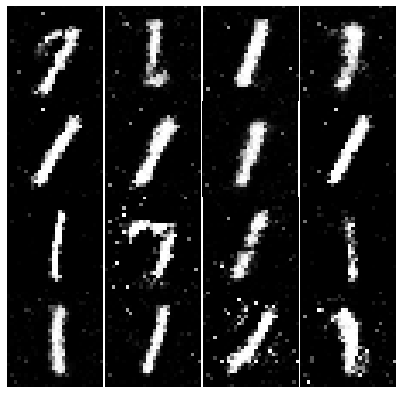

----------------------Epoch Number:48------------------------
Discriminator Loss:  0.4262039363384247 Generator Loss:  2.7578301429748535
Discriminator Loss:  0.35859543085098267 Generator Loss:  4.384819030761719
Discriminator Loss:  0.3200417160987854 Generator Loss:  3.6706461906433105
Discriminator Loss:  0.525790810585022 Generator Loss:  2.905306577682495


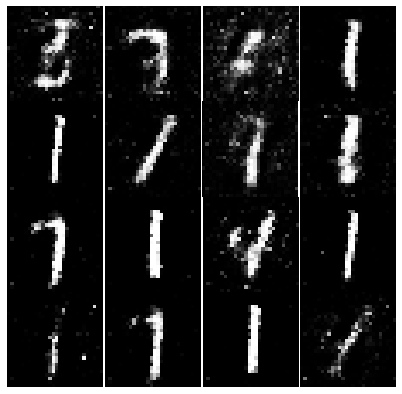

----------------------Epoch Number:49------------------------
Discriminator Loss:  0.33635926246643066 Generator Loss:  2.075928211212158
Discriminator Loss:  0.548241138458252 Generator Loss:  2.209073066711426
Discriminator Loss:  0.40340155363082886 Generator Loss:  2.9112305641174316
Discriminator Loss:  0.25852787494659424 Generator Loss:  3.7263998985290527


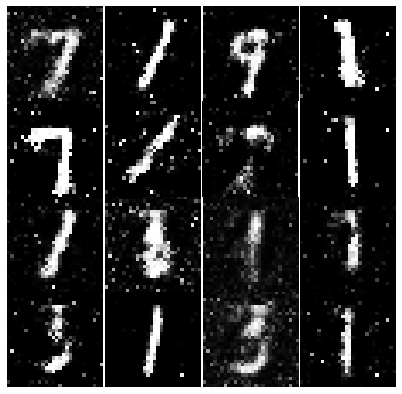

----------------------Epoch Number:50------------------------
Discriminator Loss:  0.41055893898010254 Generator Loss:  2.7003111839294434
Discriminator Loss:  0.4165775179862976 Generator Loss:  3.158085823059082
Discriminator Loss:  0.2922583222389221 Generator Loss:  3.8388638496398926
Discriminator Loss:  0.4259098470211029 Generator Loss:  3.6883840560913086


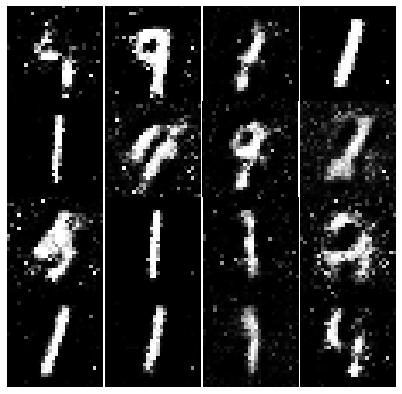

----------------------Epoch Number:51------------------------
Discriminator Loss:  0.4784070551395416 Generator Loss:  3.4777512550354004
Discriminator Loss:  0.45937594771385193 Generator Loss:  3.6378397941589355
Discriminator Loss:  0.3450832664966583 Generator Loss:  1.602790117263794
Discriminator Loss:  0.5666157007217407 Generator Loss:  2.6350693702697754


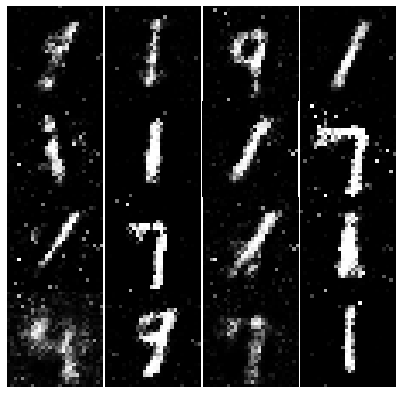

----------------------Epoch Number:52------------------------
Discriminator Loss:  0.2746463418006897 Generator Loss:  2.8413074016571045
Discriminator Loss:  0.4407964050769806 Generator Loss:  2.5011563301086426
Discriminator Loss:  0.4578692317008972 Generator Loss:  2.603726625442505
Discriminator Loss:  0.584437370300293 Generator Loss:  3.0817790031433105


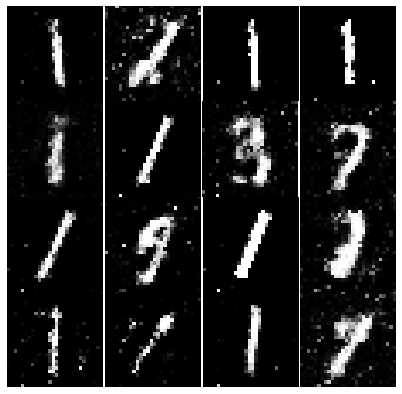

----------------------Epoch Number:53------------------------
Discriminator Loss:  0.39466845989227295 Generator Loss:  2.399287223815918
Discriminator Loss:  0.5131551027297974 Generator Loss:  1.7917308807373047
Discriminator Loss:  0.398420512676239 Generator Loss:  2.393126964569092
Discriminator Loss:  0.48688918352127075 Generator Loss:  2.659450054168701


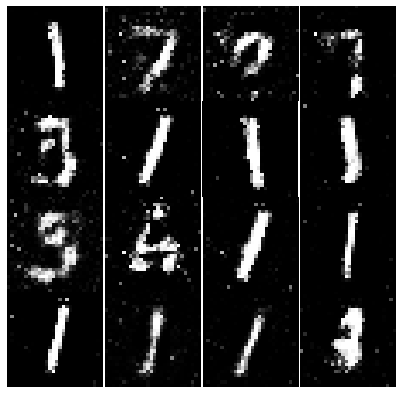

----------------------Epoch Number:54------------------------
Discriminator Loss:  0.4639269709587097 Generator Loss:  2.6390562057495117
Discriminator Loss:  0.5976725220680237 Generator Loss:  2.381974697113037
Discriminator Loss:  0.3885893225669861 Generator Loss:  3.185173988342285
Discriminator Loss:  0.49473321437835693 Generator Loss:  3.263509511947632


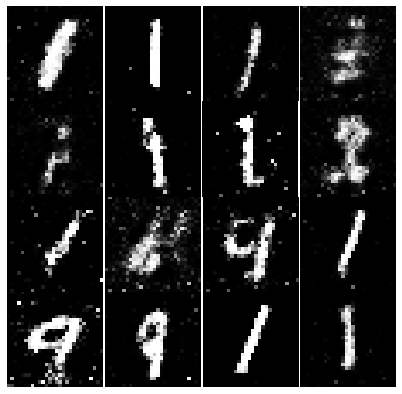

----------------------Epoch Number:55------------------------
Discriminator Loss:  0.6246039867401123 Generator Loss:  2.9395456314086914
Discriminator Loss:  0.49279487133026123 Generator Loss:  2.2335472106933594
Discriminator Loss:  0.42326706647872925 Generator Loss:  2.237846851348877
Discriminator Loss:  0.37062758207321167 Generator Loss:  2.2846264839172363


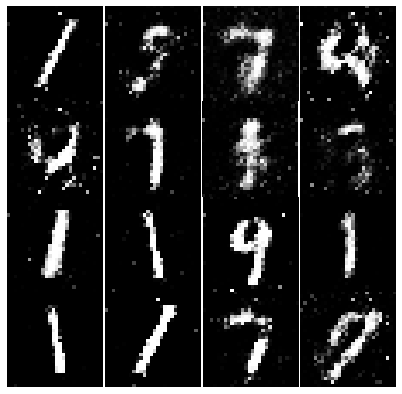

----------------------Epoch Number:56------------------------
Discriminator Loss:  0.46434271335601807 Generator Loss:  2.6393628120422363
Discriminator Loss:  0.6735175251960754 Generator Loss:  2.101970672607422
Discriminator Loss:  0.37921321392059326 Generator Loss:  3.395524263381958
Discriminator Loss:  0.48824918270111084 Generator Loss:  3.8122034072875977


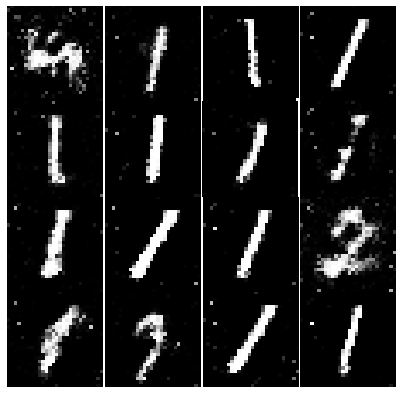

----------------------Epoch Number:57------------------------
Discriminator Loss:  0.3905332088470459 Generator Loss:  2.9624452590942383
Discriminator Loss:  0.44859635829925537 Generator Loss:  3.8022985458374023
Discriminator Loss:  0.47312772274017334 Generator Loss:  2.6630473136901855
Discriminator Loss:  0.7854032516479492 Generator Loss:  2.1330342292785645


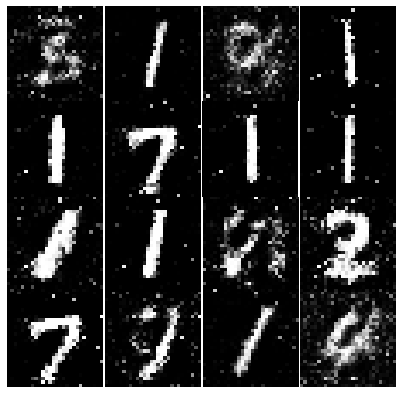

----------------------Epoch Number:58------------------------
Discriminator Loss:  0.4296087622642517 Generator Loss:  3.854785919189453
Discriminator Loss:  0.6141161322593689 Generator Loss:  2.3666372299194336
Discriminator Loss:  0.519192636013031 Generator Loss:  3.2100489139556885
Discriminator Loss:  0.5445526838302612 Generator Loss:  1.5739452838897705


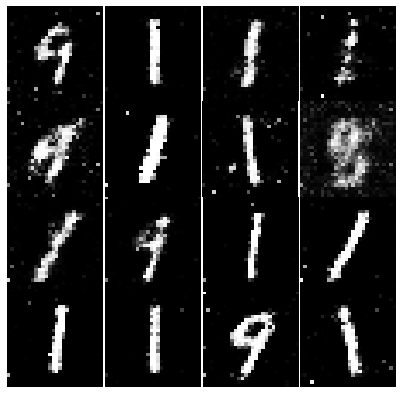

----------------------Epoch Number:59------------------------
Discriminator Loss:  0.5427083969116211 Generator Loss:  3.007375478744507
Discriminator Loss:  0.4548403024673462 Generator Loss:  2.834329128265381
Discriminator Loss:  0.4753442704677582 Generator Loss:  4.108310699462891
Discriminator Loss:  0.5410604476928711 Generator Loss:  1.9339983463287354


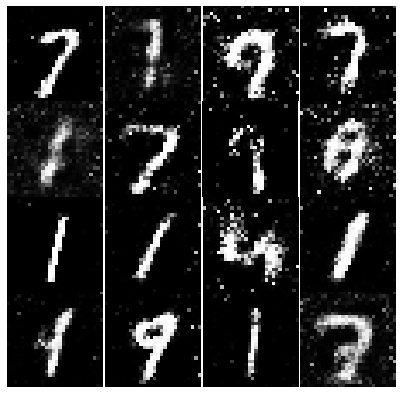

----------------------Epoch Number:60------------------------
Discriminator Loss:  0.5977999567985535 Generator Loss:  3.1105294227600098
Discriminator Loss:  0.5714150071144104 Generator Loss:  2.5776212215423584
Discriminator Loss:  0.4691746234893799 Generator Loss:  2.749173164367676
Discriminator Loss:  0.5009170770645142 Generator Loss:  2.5513055324554443


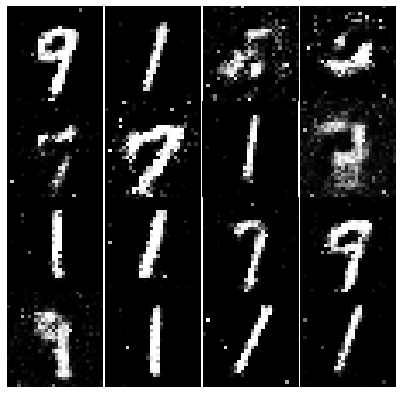

----------------------Epoch Number:61------------------------
Discriminator Loss:  0.42277488112449646 Generator Loss:  2.8360748291015625
Discriminator Loss:  0.48422229290008545 Generator Loss:  1.776160717010498
Discriminator Loss:  0.5401818752288818 Generator Loss:  2.7501490116119385
Discriminator Loss:  0.504527747631073 Generator Loss:  2.684743642807007


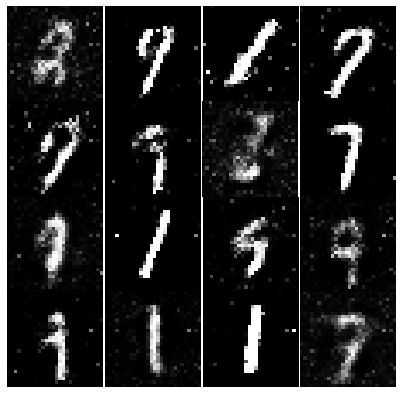

----------------------Epoch Number:62------------------------
Discriminator Loss:  0.4554077386856079 Generator Loss:  2.420928716659546
Discriminator Loss:  0.47258225083351135 Generator Loss:  2.4246816635131836
Discriminator Loss:  0.44185423851013184 Generator Loss:  3.1237106323242188
Discriminator Loss:  0.47456222772598267 Generator Loss:  2.4108083248138428


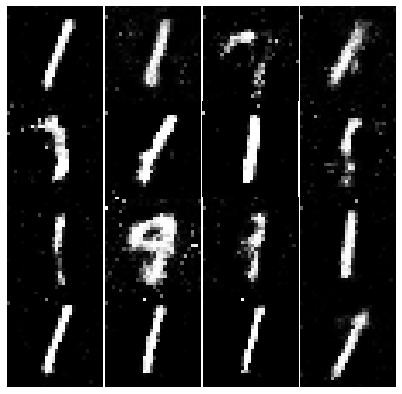

----------------------Epoch Number:63------------------------
Discriminator Loss:  0.4561799168586731 Generator Loss:  2.7545015811920166
Discriminator Loss:  0.5191220641136169 Generator Loss:  2.6780784130096436
Discriminator Loss:  0.588173508644104 Generator Loss:  2.146253824234009
Discriminator Loss:  0.43222421407699585 Generator Loss:  2.384366989135742


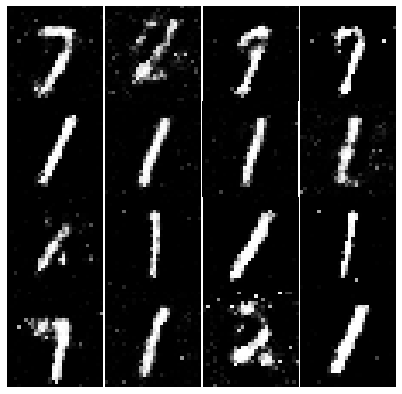

----------------------Epoch Number:64------------------------
Discriminator Loss:  0.5188338756561279 Generator Loss:  3.0251994132995605
Discriminator Loss:  0.5426207780838013 Generator Loss:  1.9219436645507812
Discriminator Loss:  0.4584888517856598 Generator Loss:  2.897489309310913
Discriminator Loss:  0.4851580262184143 Generator Loss:  2.7557296752929688


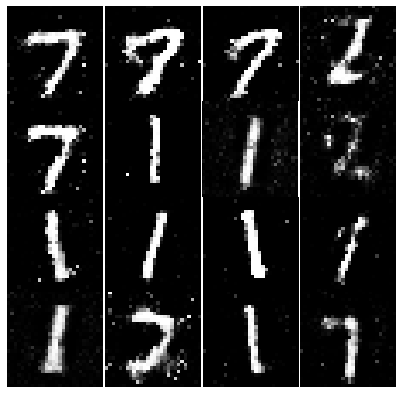

----------------------Epoch Number:65------------------------
Discriminator Loss:  0.4303441345691681 Generator Loss:  2.3620681762695312
Discriminator Loss:  0.3931775689125061 Generator Loss:  2.7318081855773926
Discriminator Loss:  0.6765462160110474 Generator Loss:  2.896134376525879
Discriminator Loss:  0.39979299902915955 Generator Loss:  2.6485788822174072


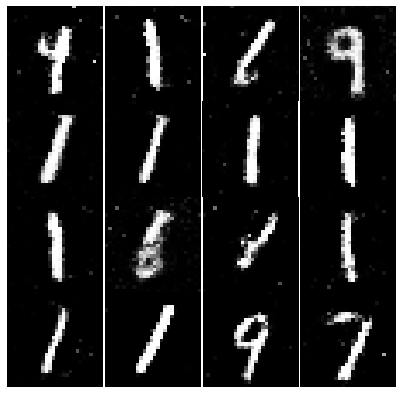

----------------------Epoch Number:66------------------------
Discriminator Loss:  0.5510610938072205 Generator Loss:  2.677661180496216
Discriminator Loss:  0.4931418299674988 Generator Loss:  2.55546236038208
Discriminator Loss:  0.4480542242527008 Generator Loss:  2.6449408531188965
Discriminator Loss:  0.4542369544506073 Generator Loss:  2.0771141052246094


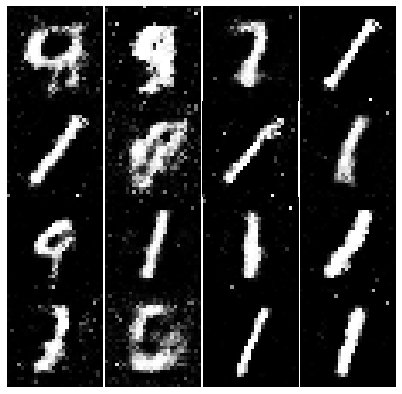

----------------------Epoch Number:67------------------------
Discriminator Loss:  0.5438166856765747 Generator Loss:  2.6606640815734863
Discriminator Loss:  0.5837811231613159 Generator Loss:  1.926539659500122
Discriminator Loss:  0.4936414062976837 Generator Loss:  2.699239492416382
Discriminator Loss:  0.5396823883056641 Generator Loss:  1.7867556810379028


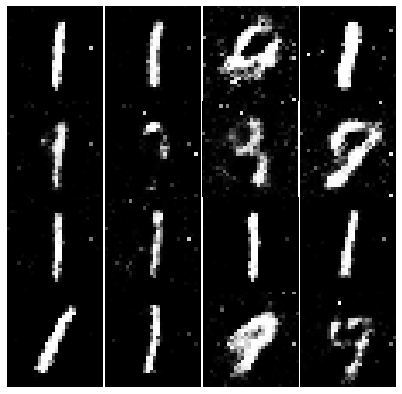

----------------------Epoch Number:68------------------------
Discriminator Loss:  0.4944286346435547 Generator Loss:  2.847053050994873
Discriminator Loss:  0.5193372964859009 Generator Loss:  2.378955364227295
Discriminator Loss:  0.4336211085319519 Generator Loss:  3.251129150390625
Discriminator Loss:  0.6356534957885742 Generator Loss:  2.372814655303955


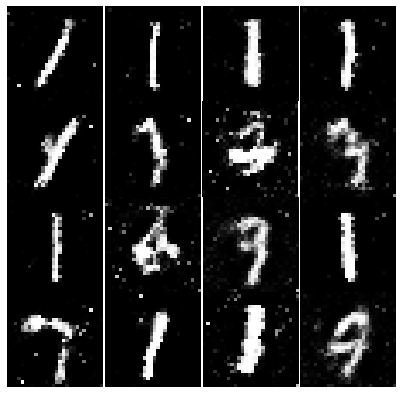

----------------------Epoch Number:69------------------------
Discriminator Loss:  0.544401228427887 Generator Loss:  1.752945899963379
Discriminator Loss:  0.5644590258598328 Generator Loss:  2.4920756816864014
Discriminator Loss:  0.5578560829162598 Generator Loss:  2.4554574489593506
Discriminator Loss:  0.6903274059295654 Generator Loss:  2.2994346618652344


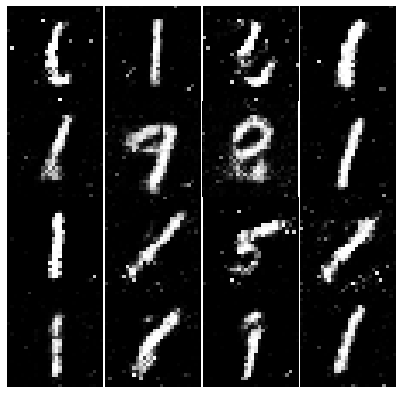

----------------------Epoch Number:70------------------------
Discriminator Loss:  0.5078062415122986 Generator Loss:  2.5233635902404785
Discriminator Loss:  0.6483153700828552 Generator Loss:  1.8151569366455078
Discriminator Loss:  0.5732109546661377 Generator Loss:  2.3537707328796387
Discriminator Loss:  0.5134528875350952 Generator Loss:  2.5238189697265625


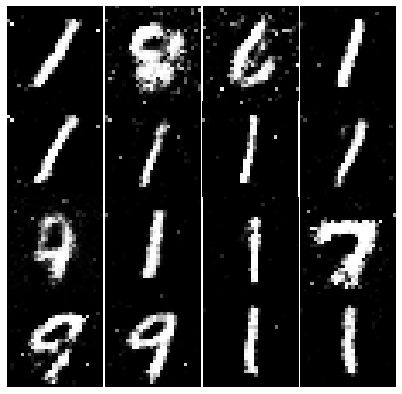

----------------------Epoch Number:71------------------------
Discriminator Loss:  0.5915021300315857 Generator Loss:  2.663576602935791
Discriminator Loss:  0.5070297122001648 Generator Loss:  2.5312952995300293
Discriminator Loss:  0.6467353105545044 Generator Loss:  2.2761878967285156
Discriminator Loss:  0.638359546661377 Generator Loss:  2.4261515140533447


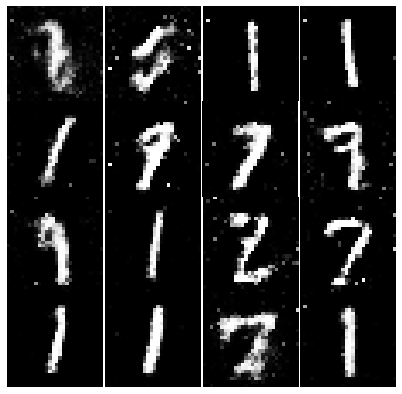

----------------------Epoch Number:72------------------------
Discriminator Loss:  0.5916037559509277 Generator Loss:  1.8098200559616089
Discriminator Loss:  0.7836589217185974 Generator Loss:  1.914179801940918
Discriminator Loss:  0.5147535800933838 Generator Loss:  2.8811211585998535
Discriminator Loss:  0.6199859380722046 Generator Loss:  2.185344696044922


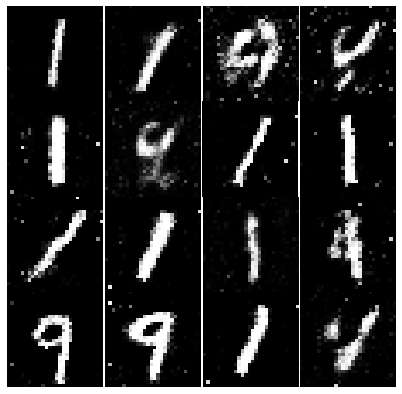

----------------------Epoch Number:73------------------------
Discriminator Loss:  0.48724424839019775 Generator Loss:  1.8897219896316528
Discriminator Loss:  0.4966141879558563 Generator Loss:  2.9085638523101807
Discriminator Loss:  0.5869826674461365 Generator Loss:  2.5289480686187744
Discriminator Loss:  0.5165766477584839 Generator Loss:  2.0370988845825195


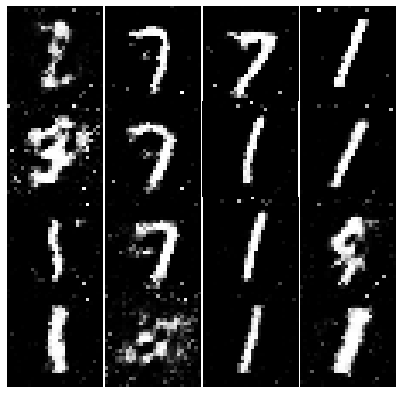

----------------------Epoch Number:74------------------------
Discriminator Loss:  0.5859817862510681 Generator Loss:  2.237863779067993
Discriminator Loss:  0.6093921661376953 Generator Loss:  2.0516750812530518
Discriminator Loss:  0.617662787437439 Generator Loss:  2.739046096801758
Discriminator Loss:  0.4595048427581787 Generator Loss:  2.1898279190063477


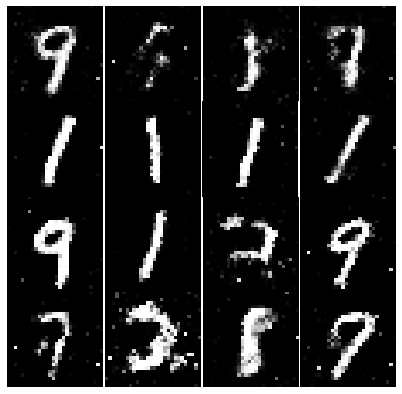

----------------------Epoch Number:75------------------------
Discriminator Loss:  0.674342691898346 Generator Loss:  2.5104103088378906
Discriminator Loss:  0.5381969213485718 Generator Loss:  2.44356632232666
Discriminator Loss:  0.5160162448883057 Generator Loss:  2.5064690113067627
Discriminator Loss:  0.5618343353271484 Generator Loss:  1.969325304031372


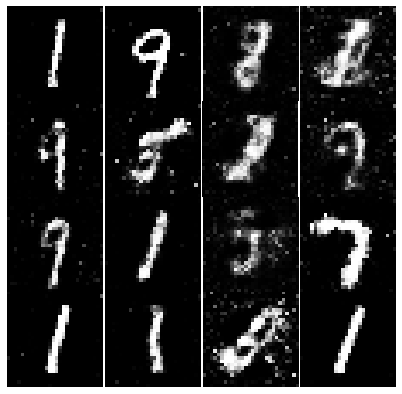

----------------------Epoch Number:76------------------------
Discriminator Loss:  0.41268521547317505 Generator Loss:  2.8284308910369873
Discriminator Loss:  0.5529734492301941 Generator Loss:  2.5465574264526367
Discriminator Loss:  0.5581265687942505 Generator Loss:  1.6740286350250244
Discriminator Loss:  0.5170643329620361 Generator Loss:  2.3568356037139893


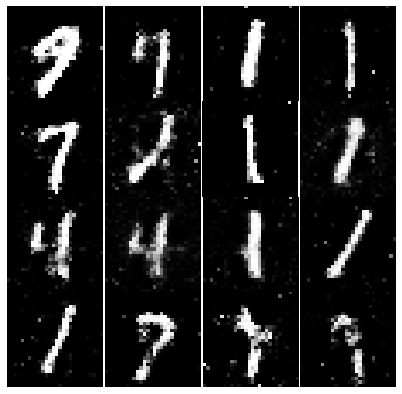

----------------------Epoch Number:77------------------------
Discriminator Loss:  0.5446656942367554 Generator Loss:  2.3205437660217285
Discriminator Loss:  0.5353025794029236 Generator Loss:  2.667541027069092
Discriminator Loss:  0.5361471176147461 Generator Loss:  2.228806495666504
Discriminator Loss:  0.5951456427574158 Generator Loss:  2.068619728088379


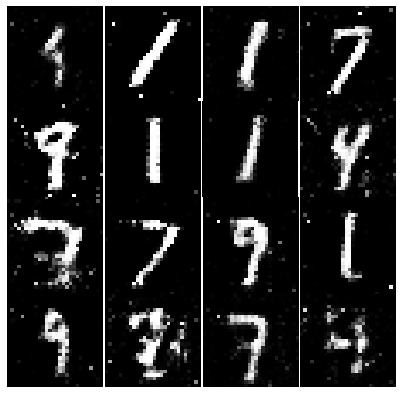

----------------------Epoch Number:78------------------------
Discriminator Loss:  0.5898116230964661 Generator Loss:  2.595895767211914
Discriminator Loss:  0.5393611788749695 Generator Loss:  2.5808985233306885
Discriminator Loss:  0.45256543159484863 Generator Loss:  2.1035289764404297
Discriminator Loss:  0.5860214233398438 Generator Loss:  2.7770986557006836


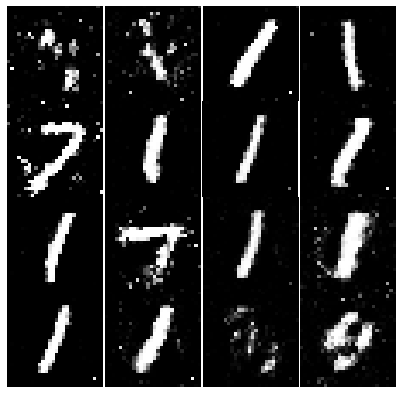

----------------------Epoch Number:79------------------------
Discriminator Loss:  0.5581859350204468 Generator Loss:  2.5055975914001465
Discriminator Loss:  0.6003525853157043 Generator Loss:  1.9319281578063965
Discriminator Loss:  0.5633265972137451 Generator Loss:  2.093505382537842
Discriminator Loss:  0.5778086185455322 Generator Loss:  1.843446135520935


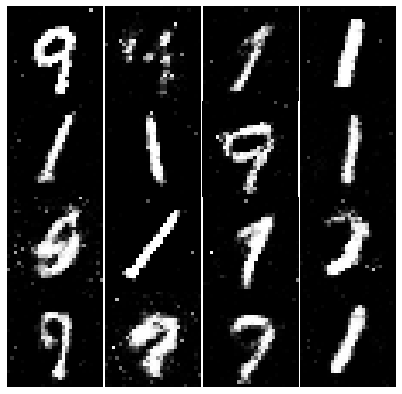

----------------------Epoch Number:80------------------------
Discriminator Loss:  0.5092380046844482 Generator Loss:  2.3721401691436768
Discriminator Loss:  0.5022262930870056 Generator Loss:  2.130514144897461
Discriminator Loss:  0.6126329898834229 Generator Loss:  2.262002944946289
Discriminator Loss:  0.5181272029876709 Generator Loss:  1.846827745437622


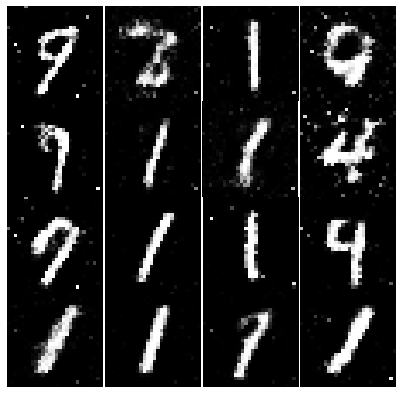

----------------------Epoch Number:81------------------------
Discriminator Loss:  0.545874834060669 Generator Loss:  2.6171844005584717
Discriminator Loss:  0.6529134511947632 Generator Loss:  1.9092832803726196
Discriminator Loss:  0.4825977087020874 Generator Loss:  2.0467662811279297
Discriminator Loss:  0.4509752094745636 Generator Loss:  2.403657913208008


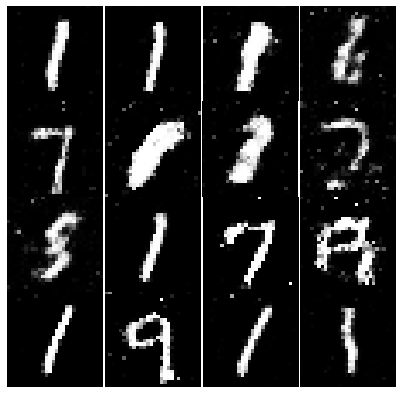

----------------------Epoch Number:82------------------------
Discriminator Loss:  0.6592164635658264 Generator Loss:  1.965110421180725
Discriminator Loss:  0.6804182529449463 Generator Loss:  1.8361692428588867
Discriminator Loss:  0.719672441482544 Generator Loss:  2.366016149520874
Discriminator Loss:  0.4921678602695465 Generator Loss:  2.006525993347168


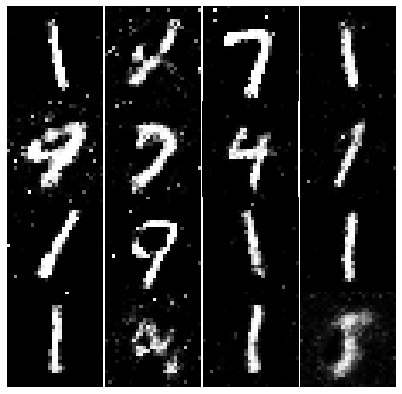

----------------------Epoch Number:83------------------------
Discriminator Loss:  0.5901040434837341 Generator Loss:  2.4699816703796387
Discriminator Loss:  0.5631886124610901 Generator Loss:  2.361729621887207
Discriminator Loss:  0.594685971736908 Generator Loss:  1.6626266241073608
Discriminator Loss:  0.5708534717559814 Generator Loss:  2.189695358276367


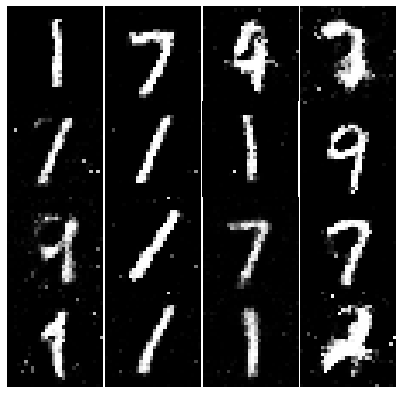

----------------------Epoch Number:84------------------------
Discriminator Loss:  0.5750646591186523 Generator Loss:  1.8827033042907715
Discriminator Loss:  0.5240535736083984 Generator Loss:  1.6329740285873413
Discriminator Loss:  0.6170628666877747 Generator Loss:  1.6242661476135254
Discriminator Loss:  0.7253589630126953 Generator Loss:  1.5951179265975952


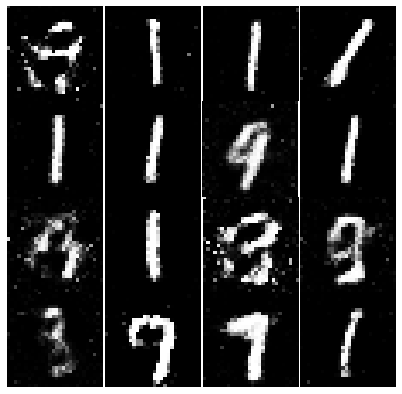

----------------------Epoch Number:85------------------------
Discriminator Loss:  0.5452380180358887 Generator Loss:  2.0698959827423096
Discriminator Loss:  0.5940036773681641 Generator Loss:  2.393444299697876
Discriminator Loss:  0.5846462249755859 Generator Loss:  2.0332841873168945
Discriminator Loss:  0.5982856750488281 Generator Loss:  1.971195101737976


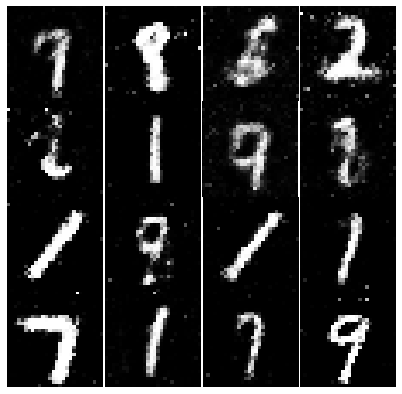

----------------------Epoch Number:86------------------------
Discriminator Loss:  0.5052868723869324 Generator Loss:  2.309190511703491
Discriminator Loss:  0.695059061050415 Generator Loss:  1.8278312683105469
Discriminator Loss:  0.5984750986099243 Generator Loss:  2.114236831665039
Discriminator Loss:  0.5341777801513672 Generator Loss:  2.152562141418457


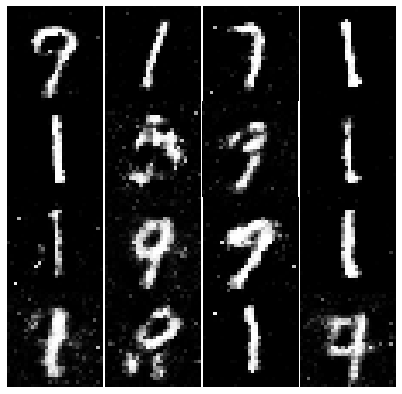

----------------------Epoch Number:87------------------------
Discriminator Loss:  0.6987026929855347 Generator Loss:  1.7813109159469604
Discriminator Loss:  0.6970416307449341 Generator Loss:  1.9043174982070923
Discriminator Loss:  0.7509318590164185 Generator Loss:  2.37320613861084
Discriminator Loss:  0.5946776866912842 Generator Loss:  2.2358622550964355


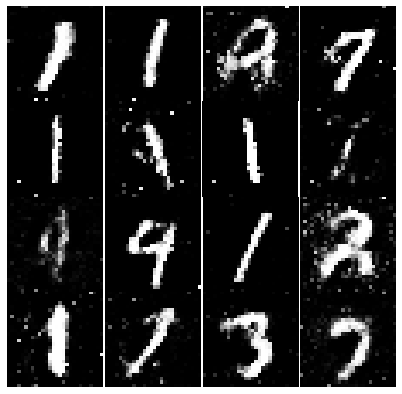

----------------------Epoch Number:88------------------------
Discriminator Loss:  0.4486791491508484 Generator Loss:  2.229161262512207
Discriminator Loss:  0.6083769202232361 Generator Loss:  2.3075313568115234
Discriminator Loss:  0.5365800857543945 Generator Loss:  1.8156657218933105
Discriminator Loss:  0.5543102025985718 Generator Loss:  1.9150913953781128


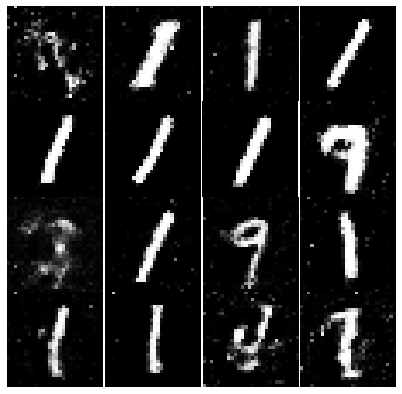

----------------------Epoch Number:89------------------------
Discriminator Loss:  0.5537000298500061 Generator Loss:  1.4521167278289795
Discriminator Loss:  0.6758732199668884 Generator Loss:  2.7885169982910156
Discriminator Loss:  0.6764603853225708 Generator Loss:  1.9937186241149902
Discriminator Loss:  0.7422691583633423 Generator Loss:  1.7063124179840088


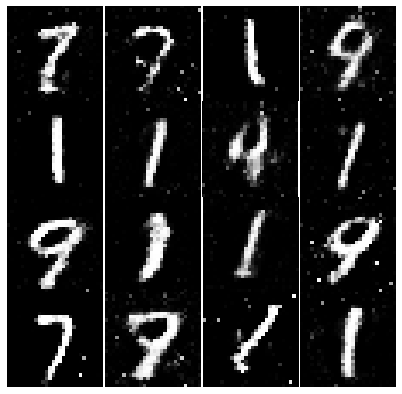

----------------------Epoch Number:90------------------------
Discriminator Loss:  0.7240715622901917 Generator Loss:  2.1222472190856934
Discriminator Loss:  0.6102433204650879 Generator Loss:  1.7863903045654297
Discriminator Loss:  0.5962943434715271 Generator Loss:  1.9035660028457642
Discriminator Loss:  0.6569333076477051 Generator Loss:  1.7858275175094604


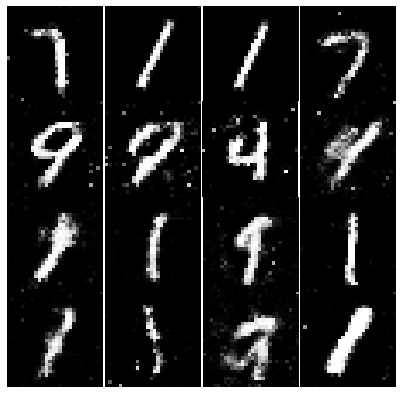

----------------------Epoch Number:91------------------------
Discriminator Loss:  0.6617457270622253 Generator Loss:  2.6027464866638184
Discriminator Loss:  0.5932930707931519 Generator Loss:  1.7546765804290771
Discriminator Loss:  0.6099317669868469 Generator Loss:  1.8427956104278564
Discriminator Loss:  0.5819424390792847 Generator Loss:  2.4029603004455566


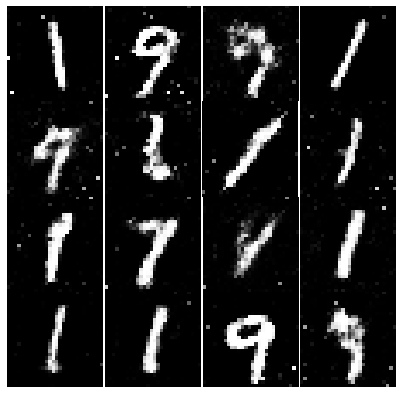

----------------------Epoch Number:92------------------------
Discriminator Loss:  0.7143688201904297 Generator Loss:  2.011483907699585
Discriminator Loss:  0.5631901025772095 Generator Loss:  2.1253247261047363
Discriminator Loss:  0.5355087518692017 Generator Loss:  1.8455617427825928
Discriminator Loss:  0.5840120315551758 Generator Loss:  2.2531931400299072


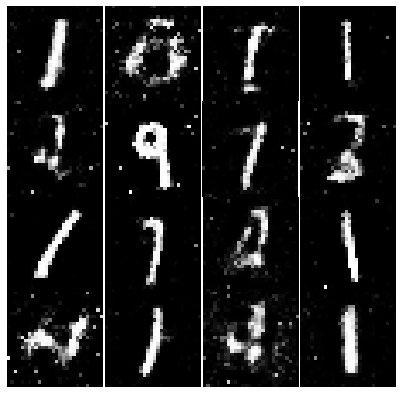

----------------------Epoch Number:93------------------------
Discriminator Loss:  0.5939125418663025 Generator Loss:  2.7707486152648926
Discriminator Loss:  0.6122901439666748 Generator Loss:  1.802842378616333
Discriminator Loss:  0.6237363815307617 Generator Loss:  2.6669654846191406
Discriminator Loss:  0.6929926872253418 Generator Loss:  2.1068124771118164


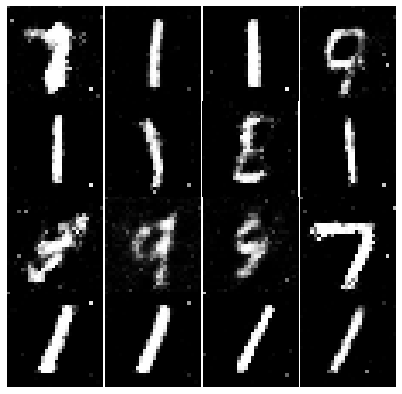

----------------------Epoch Number:94------------------------
Discriminator Loss:  0.5884041786193848 Generator Loss:  1.863253116607666
Discriminator Loss:  0.6717881560325623 Generator Loss:  2.025433301925659
Discriminator Loss:  0.652068018913269 Generator Loss:  2.072793960571289
Discriminator Loss:  0.6307030916213989 Generator Loss:  1.9443793296813965


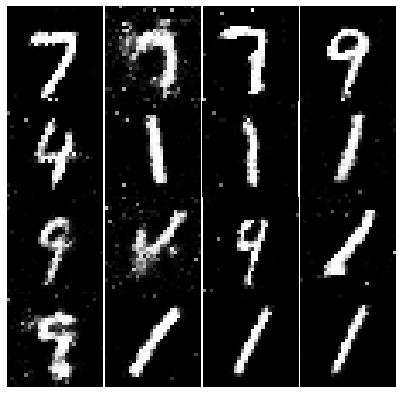

----------------------Epoch Number:95------------------------
Discriminator Loss:  0.6148861646652222 Generator Loss:  2.100989818572998
Discriminator Loss:  0.6704382300376892 Generator Loss:  1.681791067123413
Discriminator Loss:  0.6399273872375488 Generator Loss:  2.068061351776123
Discriminator Loss:  0.6670260429382324 Generator Loss:  2.3115615844726562


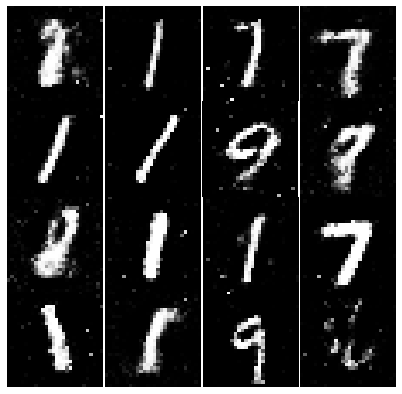

----------------------Epoch Number:96------------------------
Discriminator Loss:  0.5809988975524902 Generator Loss:  2.295620918273926
Discriminator Loss:  0.6399128437042236 Generator Loss:  1.7834742069244385
Discriminator Loss:  0.5370181798934937 Generator Loss:  1.723046064376831
Discriminator Loss:  0.5942805409431458 Generator Loss:  2.124692440032959


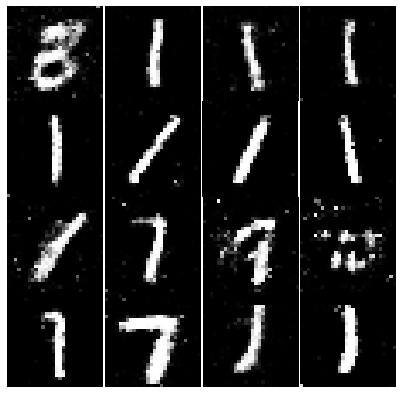

----------------------Epoch Number:97------------------------
Discriminator Loss:  0.5347540378570557 Generator Loss:  2.537367343902588
Discriminator Loss:  0.5823696851730347 Generator Loss:  2.3208694458007812
Discriminator Loss:  0.5547606348991394 Generator Loss:  2.286623954772949
Discriminator Loss:  0.6919697523117065 Generator Loss:  1.7565628290176392


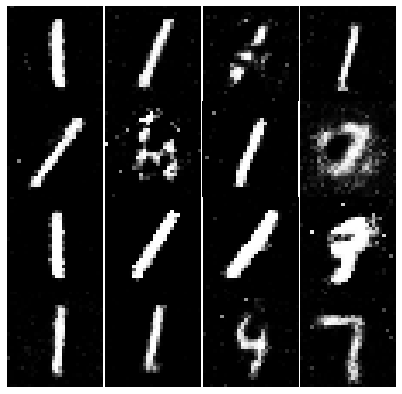

----------------------Epoch Number:98------------------------
Discriminator Loss:  0.6717603206634521 Generator Loss:  1.710378646850586
Discriminator Loss:  0.5727639198303223 Generator Loss:  2.3049373626708984
Discriminator Loss:  0.7193316221237183 Generator Loss:  2.1816675662994385
Discriminator Loss:  0.6718320846557617 Generator Loss:  2.298643112182617


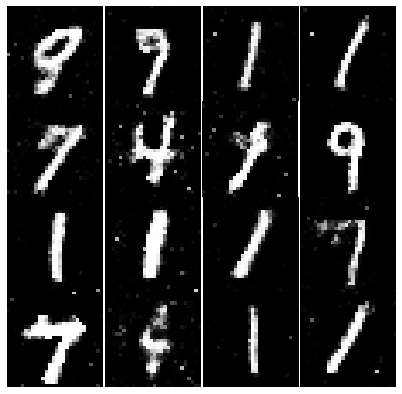

----------------------Epoch Number:99------------------------
Discriminator Loss:  0.6867044568061829 Generator Loss:  2.031585931777954
Discriminator Loss:  0.6082450151443481 Generator Loss:  1.9274731874465942
Discriminator Loss:  0.5759379267692566 Generator Loss:  1.874049186706543
Discriminator Loss:  0.6872467994689941 Generator Loss:  1.5360420942306519


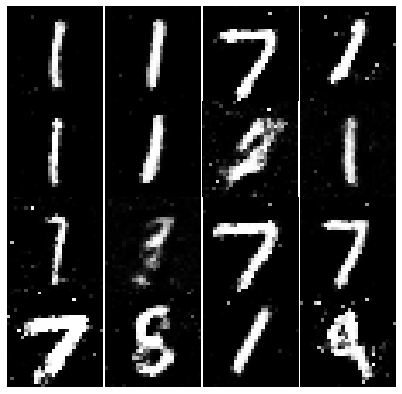

----------------------Epoch Number:100------------------------
Discriminator Loss:  0.5757279992103577 Generator Loss:  2.187286376953125
Discriminator Loss:  0.5408151149749756 Generator Loss:  1.8128407001495361
Discriminator Loss:  0.8486714363098145 Generator Loss:  2.149822235107422
Discriminator Loss:  0.7618581056594849 Generator Loss:  1.7806164026260376


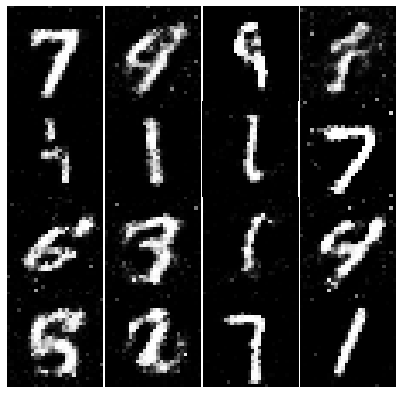

----------------------Epoch Number:101------------------------
Discriminator Loss:  0.5636908411979675 Generator Loss:  1.8074681758880615
Discriminator Loss:  0.6937392950057983 Generator Loss:  2.0916554927825928
Discriminator Loss:  0.690669596195221 Generator Loss:  1.708294153213501
Discriminator Loss:  0.813829243183136 Generator Loss:  1.67643404006958


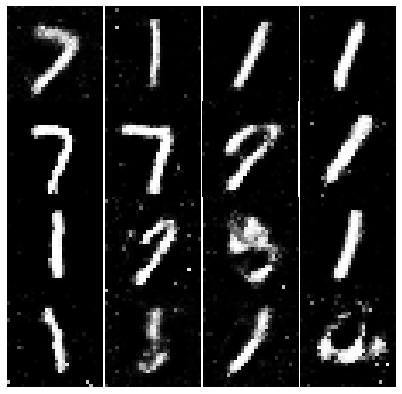

----------------------Epoch Number:102------------------------
Discriminator Loss:  0.6259903907775879 Generator Loss:  1.912955641746521
Discriminator Loss:  0.8048355579376221 Generator Loss:  1.8684927225112915
Discriminator Loss:  0.5361446142196655 Generator Loss:  1.7233257293701172
Discriminator Loss:  0.6438792943954468 Generator Loss:  1.9876201152801514


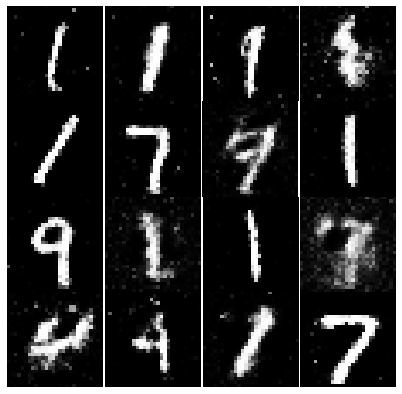

----------------------Epoch Number:103------------------------
Discriminator Loss:  0.7267045378684998 Generator Loss:  1.8654277324676514
Discriminator Loss:  0.6102039813995361 Generator Loss:  1.646859884262085
Discriminator Loss:  0.5051833987236023 Generator Loss:  1.8599791526794434
Discriminator Loss:  0.6111356616020203 Generator Loss:  2.151493549346924


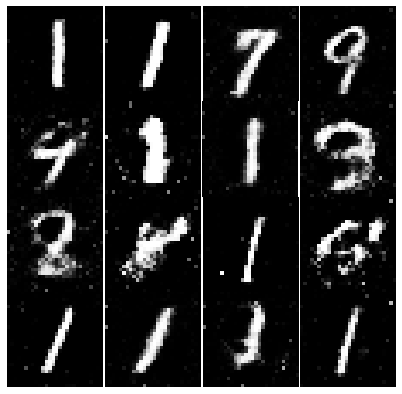

----------------------Epoch Number:104------------------------
Discriminator Loss:  0.6040352582931519 Generator Loss:  1.672027826309204
Discriminator Loss:  0.6365955471992493 Generator Loss:  1.9503611326217651
Discriminator Loss:  0.8429664373397827 Generator Loss:  1.8729588985443115
Discriminator Loss:  0.6772866249084473 Generator Loss:  2.003657341003418


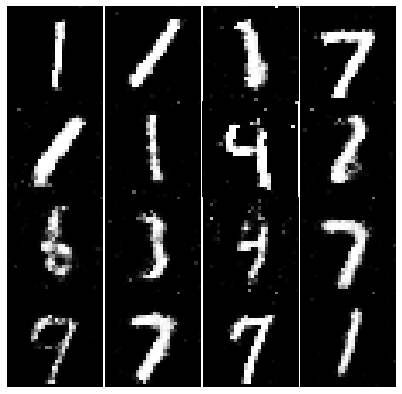

----------------------Epoch Number:105------------------------
Discriminator Loss:  0.5544541478157043 Generator Loss:  1.584313988685608
Discriminator Loss:  0.7908281087875366 Generator Loss:  1.7071878910064697
Discriminator Loss:  0.686916172504425 Generator Loss:  1.868461012840271
Discriminator Loss:  0.640985369682312 Generator Loss:  1.8152331113815308


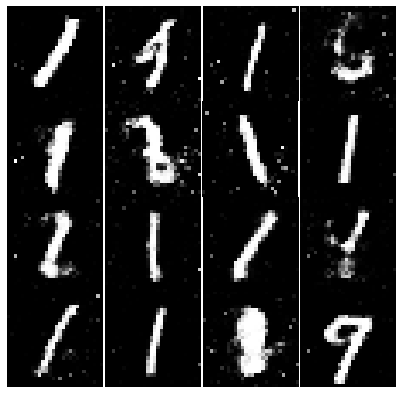

----------------------Epoch Number:106------------------------
Discriminator Loss:  0.653684675693512 Generator Loss:  1.8566644191741943
Discriminator Loss:  0.7185224294662476 Generator Loss:  2.4611620903015137
Discriminator Loss:  0.6332200765609741 Generator Loss:  1.6530659198760986
Discriminator Loss:  0.8421633243560791 Generator Loss:  1.5743478536605835


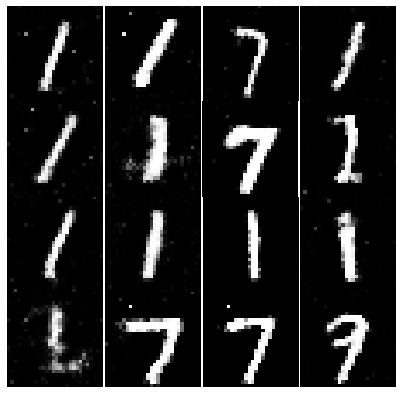

----------------------Epoch Number:107------------------------
Discriminator Loss:  0.672491729259491 Generator Loss:  1.6204019784927368
Discriminator Loss:  0.5428794026374817 Generator Loss:  2.2484686374664307
Discriminator Loss:  0.48807984590530396 Generator Loss:  2.4192733764648438
Discriminator Loss:  0.5543656945228577 Generator Loss:  2.0773918628692627


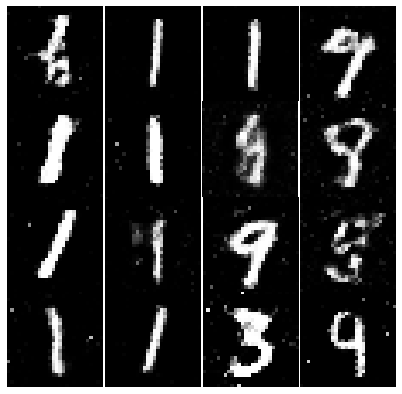

----------------------Epoch Number:108------------------------
Discriminator Loss:  0.6805492639541626 Generator Loss:  2.1858768463134766
Discriminator Loss:  0.6248022317886353 Generator Loss:  2.0916450023651123
Discriminator Loss:  0.46223342418670654 Generator Loss:  1.9656249284744263
Discriminator Loss:  0.6991854310035706 Generator Loss:  1.7000501155853271


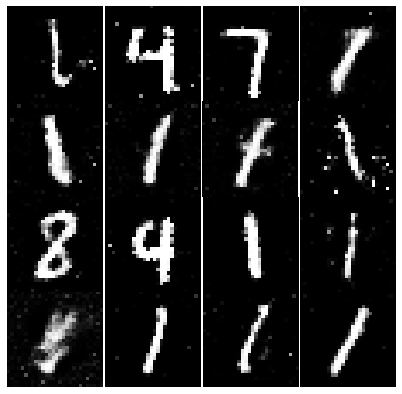

----------------------Epoch Number:109------------------------
Discriminator Loss:  0.7187840342521667 Generator Loss:  1.8644509315490723
Discriminator Loss:  0.6504490971565247 Generator Loss:  2.0485928058624268
Discriminator Loss:  0.6989935636520386 Generator Loss:  1.7364330291748047
Discriminator Loss:  0.5822954177856445 Generator Loss:  1.916833519935608


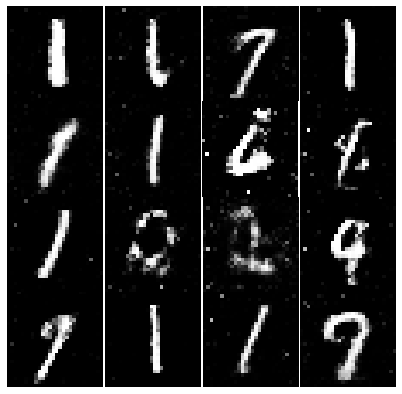

----------------------Epoch Number:110------------------------
Discriminator Loss:  0.7183481454849243 Generator Loss:  1.7944462299346924
Discriminator Loss:  0.7312874794006348 Generator Loss:  2.089801788330078
Discriminator Loss:  0.6982234716415405 Generator Loss:  2.114227056503296
Discriminator Loss:  0.6623814702033997 Generator Loss:  1.6612870693206787


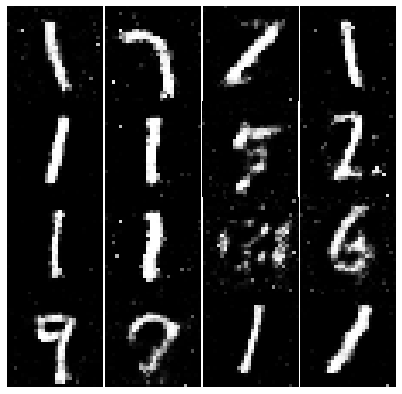

----------------------Epoch Number:111------------------------
Discriminator Loss:  0.6456916332244873 Generator Loss:  1.863417387008667
Discriminator Loss:  0.7390357255935669 Generator Loss:  1.5841314792633057
Discriminator Loss:  0.7162461876869202 Generator Loss:  2.157438039779663
Discriminator Loss:  0.6539352536201477 Generator Loss:  1.8580893278121948


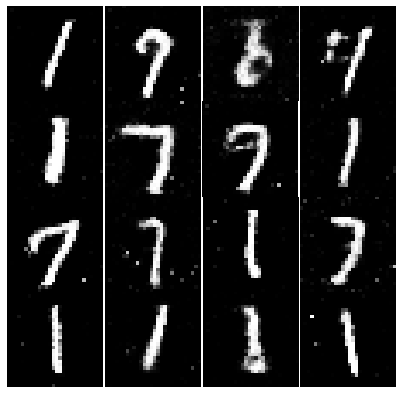

----------------------Epoch Number:112------------------------
Discriminator Loss:  0.6787477731704712 Generator Loss:  1.6302621364593506
Discriminator Loss:  0.7080172896385193 Generator Loss:  1.8629380464553833
Discriminator Loss:  0.6942122578620911 Generator Loss:  2.1316585540771484
Discriminator Loss:  0.780388593673706 Generator Loss:  2.380856513977051


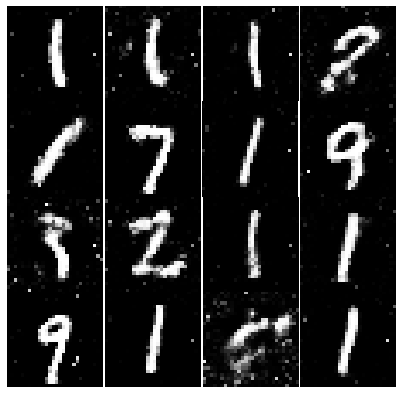

----------------------Epoch Number:113------------------------
Discriminator Loss:  0.7867680191993713 Generator Loss:  1.7002980709075928
Discriminator Loss:  0.753070056438446 Generator Loss:  1.7692532539367676
Discriminator Loss:  0.6158603429794312 Generator Loss:  1.549868106842041
Discriminator Loss:  0.7194731831550598 Generator Loss:  2.4023256301879883


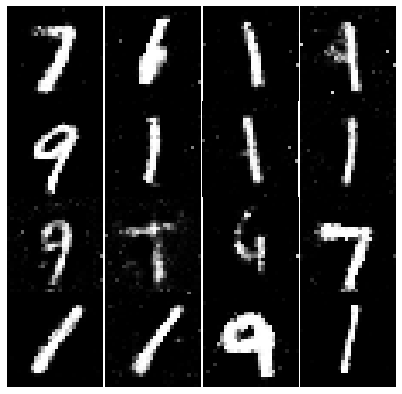

----------------------Epoch Number:114------------------------
Discriminator Loss:  0.643620491027832 Generator Loss:  1.8910560607910156
Discriminator Loss:  0.7748192548751831 Generator Loss:  1.947023630142212
Discriminator Loss:  0.6191713809967041 Generator Loss:  1.6085611581802368
Discriminator Loss:  0.7299425601959229 Generator Loss:  1.734066367149353


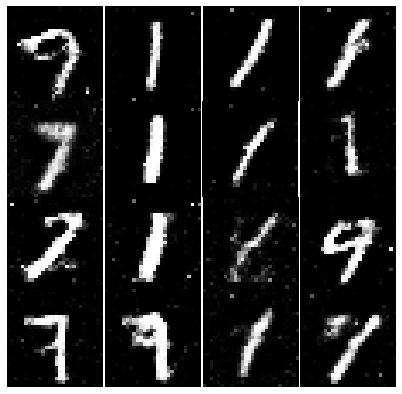

----------------------Epoch Number:115------------------------
Discriminator Loss:  0.6636489629745483 Generator Loss:  1.9171640872955322
Discriminator Loss:  0.8018168210983276 Generator Loss:  1.4366391897201538
Discriminator Loss:  0.8753960728645325 Generator Loss:  1.5360472202301025
Discriminator Loss:  0.47952505946159363 Generator Loss:  2.1246562004089355


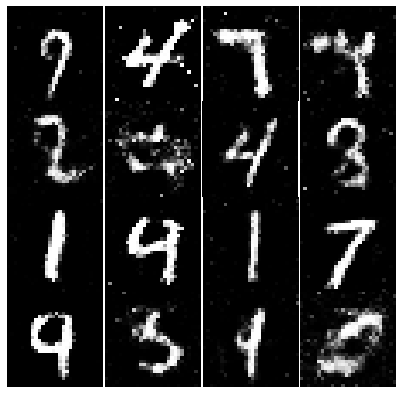

----------------------Epoch Number:116------------------------
Discriminator Loss:  0.623272716999054 Generator Loss:  1.6985886096954346
Discriminator Loss:  0.6659945249557495 Generator Loss:  1.5708208084106445
Discriminator Loss:  0.6859830021858215 Generator Loss:  1.6386898756027222
Discriminator Loss:  0.6197670698165894 Generator Loss:  1.5727157592773438


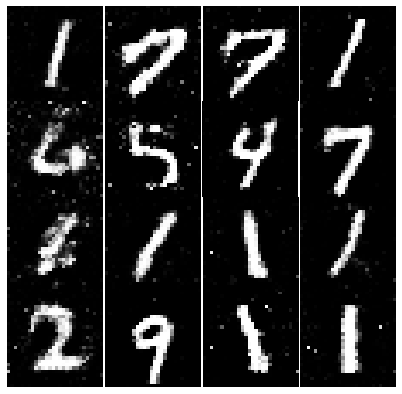

----------------------Epoch Number:117------------------------
Discriminator Loss:  0.5576769709587097 Generator Loss:  1.8419814109802246
Discriminator Loss:  0.6475732922554016 Generator Loss:  1.8375288248062134
Discriminator Loss:  0.7269048690795898 Generator Loss:  1.7898006439208984
Discriminator Loss:  0.800957202911377 Generator Loss:  1.7974157333374023


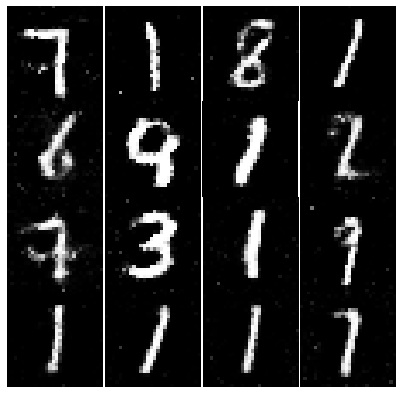

----------------------Epoch Number:118------------------------
Discriminator Loss:  0.6591991186141968 Generator Loss:  1.764350414276123
Discriminator Loss:  0.7991952896118164 Generator Loss:  1.568748950958252
Discriminator Loss:  0.6913752555847168 Generator Loss:  2.1473193168640137
Discriminator Loss:  0.6853572130203247 Generator Loss:  2.158026933670044


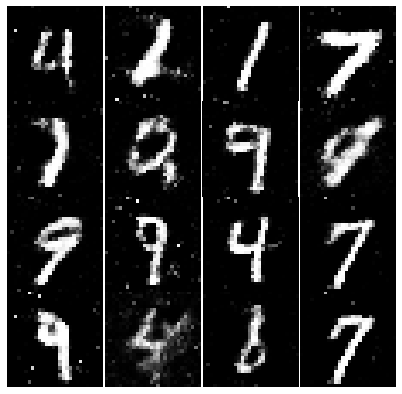

----------------------Epoch Number:119------------------------
Discriminator Loss:  0.7199919819831848 Generator Loss:  1.5792196989059448
Discriminator Loss:  0.8766521215438843 Generator Loss:  1.6228588819503784
Discriminator Loss:  0.727048933506012 Generator Loss:  1.7175860404968262
Discriminator Loss:  0.743051290512085 Generator Loss:  1.8579882383346558


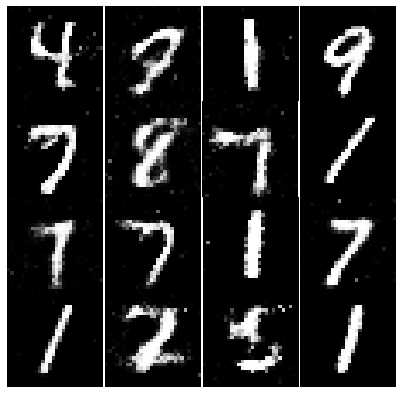

----------------------Epoch Number:120------------------------
Discriminator Loss:  0.7366087436676025 Generator Loss:  1.2972010374069214
Discriminator Loss:  0.6772457361221313 Generator Loss:  1.4498792886734009
Discriminator Loss:  0.7271973490715027 Generator Loss:  1.5465935468673706
Discriminator Loss:  0.8302799463272095 Generator Loss:  1.642362356185913


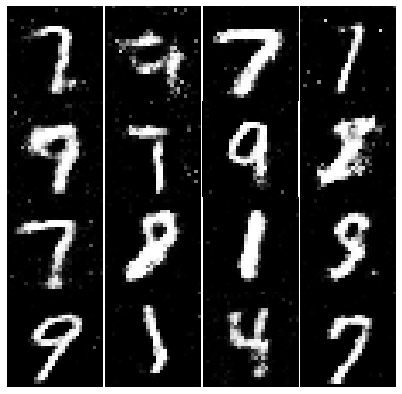

----------------------Epoch Number:121------------------------
Discriminator Loss:  0.749199390411377 Generator Loss:  1.455370545387268
Discriminator Loss:  0.7217292189598083 Generator Loss:  1.9155826568603516
Discriminator Loss:  0.8477166891098022 Generator Loss:  1.7197160720825195
Discriminator Loss:  0.7373638153076172 Generator Loss:  1.7404000759124756


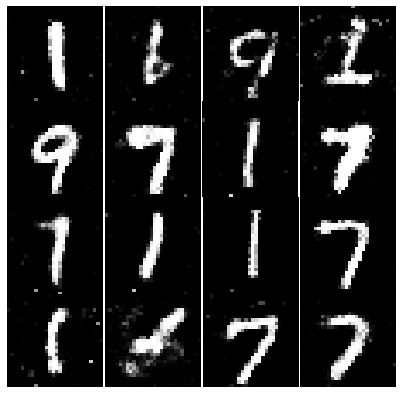

----------------------Epoch Number:122------------------------
Discriminator Loss:  0.7455264925956726 Generator Loss:  1.5307414531707764
Discriminator Loss:  0.6104608178138733 Generator Loss:  1.4876794815063477
Discriminator Loss:  0.6514778137207031 Generator Loss:  1.810303807258606
Discriminator Loss:  0.8367809057235718 Generator Loss:  1.8715273141860962


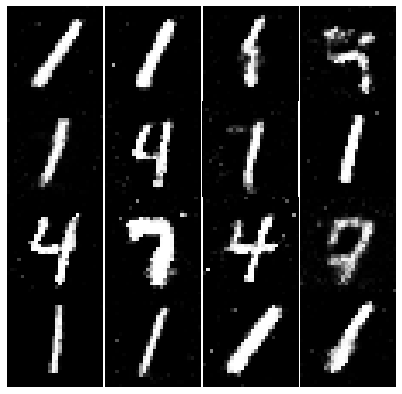

----------------------Epoch Number:123------------------------
Discriminator Loss:  0.5803220272064209 Generator Loss:  1.6631364822387695
Discriminator Loss:  0.7069509029388428 Generator Loss:  2.067831516265869
Discriminator Loss:  0.685032844543457 Generator Loss:  2.376509189605713
Discriminator Loss:  0.5352815389633179 Generator Loss:  1.7495813369750977


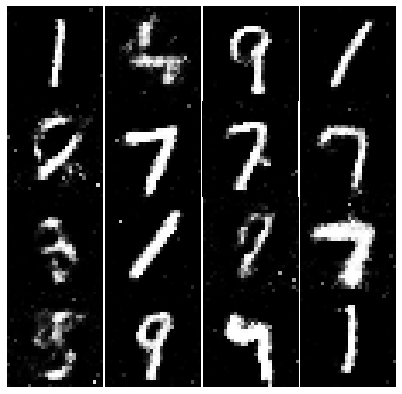

----------------------Epoch Number:124------------------------
Discriminator Loss:  0.6694121360778809 Generator Loss:  1.7442176342010498
Discriminator Loss:  0.7023090124130249 Generator Loss:  1.557294487953186
Discriminator Loss:  0.5709645748138428 Generator Loss:  2.101761817932129
Discriminator Loss:  0.6707994937896729 Generator Loss:  1.6327016353607178


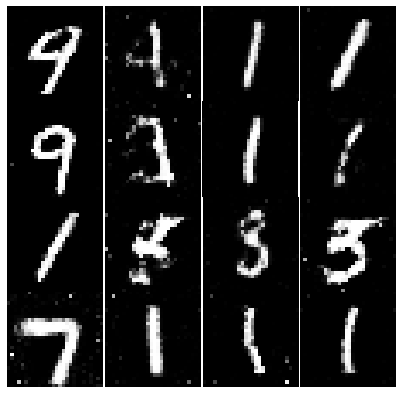

----------------------Epoch Number:125------------------------
Discriminator Loss:  0.7814979553222656 Generator Loss:  2.024001121520996
Discriminator Loss:  0.7084546685218811 Generator Loss:  1.7534164190292358
Discriminator Loss:  0.7380714416503906 Generator Loss:  2.178873062133789
Discriminator Loss:  0.7837094068527222 Generator Loss:  1.7174490690231323


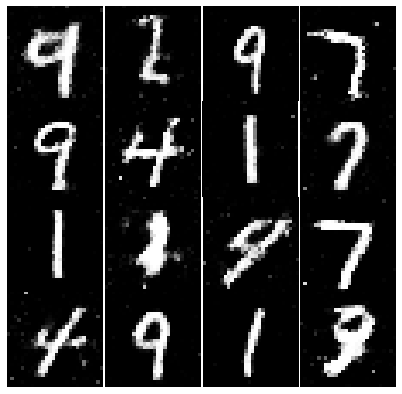

----------------------Epoch Number:126------------------------
Discriminator Loss:  0.7664234042167664 Generator Loss:  2.1990628242492676
Discriminator Loss:  0.6687041521072388 Generator Loss:  1.5715060234069824
Discriminator Loss:  0.7081629037857056 Generator Loss:  1.7822576761245728
Discriminator Loss:  0.6773124933242798 Generator Loss:  1.8199591636657715


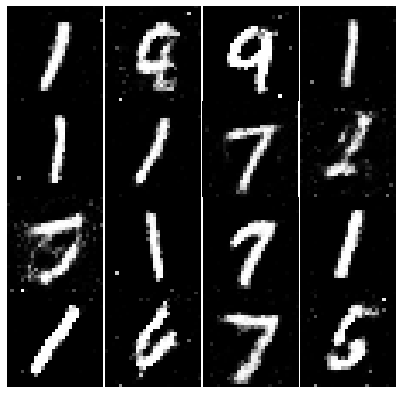

----------------------Epoch Number:127------------------------
Discriminator Loss:  0.846310019493103 Generator Loss:  1.9902853965759277
Discriminator Loss:  0.6910874247550964 Generator Loss:  2.1521267890930176
Discriminator Loss:  0.780879020690918 Generator Loss:  1.8563940525054932
Discriminator Loss:  0.7273068428039551 Generator Loss:  2.0298447608947754


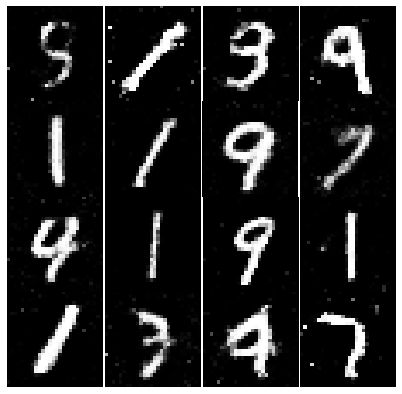

----------------------Epoch Number:128------------------------
Discriminator Loss:  0.6886608600616455 Generator Loss:  1.6977200508117676
Discriminator Loss:  0.8684923648834229 Generator Loss:  1.3618454933166504
Discriminator Loss:  0.9145669341087341 Generator Loss:  1.642240285873413
Discriminator Loss:  0.8080558776855469 Generator Loss:  1.8984196186065674


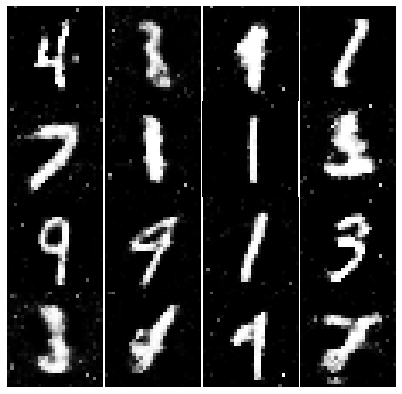

----------------------Epoch Number:129------------------------
Discriminator Loss:  0.646584153175354 Generator Loss:  1.912334680557251
Discriminator Loss:  0.6446394920349121 Generator Loss:  1.4523038864135742
Discriminator Loss:  0.8177236318588257 Generator Loss:  1.630415678024292
Discriminator Loss:  0.5710723400115967 Generator Loss:  1.453029751777649


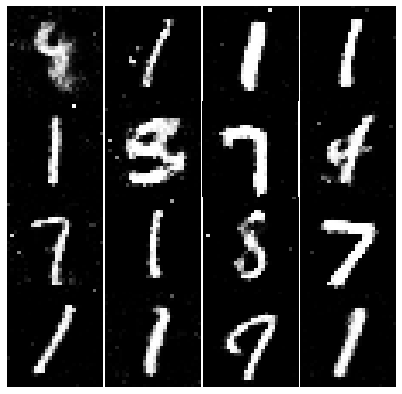

----------------------Epoch Number:130------------------------
Discriminator Loss:  0.6959090232849121 Generator Loss:  2.3142406940460205
Discriminator Loss:  0.7259999513626099 Generator Loss:  1.9237080812454224
Discriminator Loss:  0.6614065170288086 Generator Loss:  2.1568379402160645
Discriminator Loss:  0.7757032513618469 Generator Loss:  1.3146480321884155


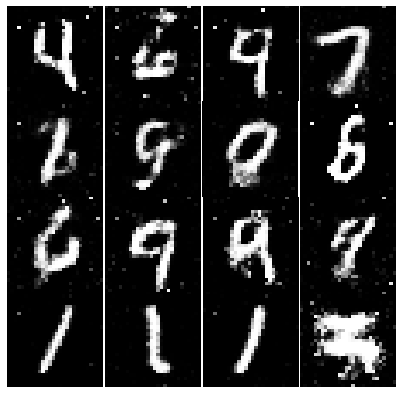

----------------------Epoch Number:131------------------------
Discriminator Loss:  0.583303689956665 Generator Loss:  2.1988186836242676
Discriminator Loss:  0.6435205936431885 Generator Loss:  2.4711151123046875
Discriminator Loss:  0.7804127931594849 Generator Loss:  1.4362599849700928
Discriminator Loss:  0.7836076021194458 Generator Loss:  1.4994091987609863


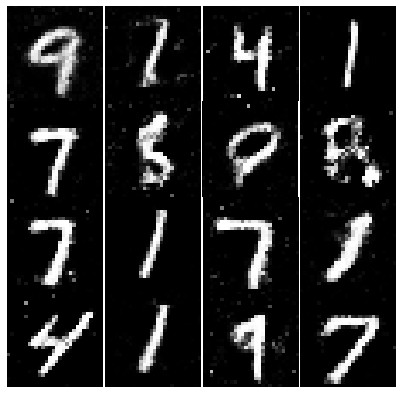

----------------------Epoch Number:132------------------------
Discriminator Loss:  0.6921913623809814 Generator Loss:  2.0593714714050293
Discriminator Loss:  0.6483684182167053 Generator Loss:  1.8908711671829224
Discriminator Loss:  0.6646219491958618 Generator Loss:  1.8910911083221436
Discriminator Loss:  0.7809362411499023 Generator Loss:  1.6398273706436157


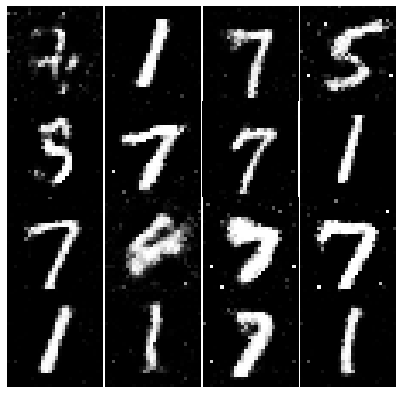

----------------------Epoch Number:133------------------------
Discriminator Loss:  0.7537078261375427 Generator Loss:  2.153735637664795
Discriminator Loss:  0.8020296692848206 Generator Loss:  1.7286616563796997
Discriminator Loss:  0.7540086507797241 Generator Loss:  2.035968780517578
Discriminator Loss:  0.6732367277145386 Generator Loss:  1.9220008850097656


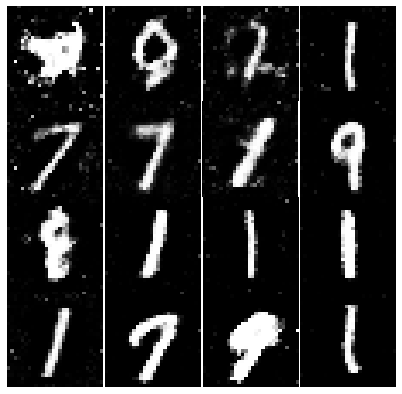

----------------------Epoch Number:134------------------------
Discriminator Loss:  0.7300871014595032 Generator Loss:  1.6830130815505981
Discriminator Loss:  0.640606164932251 Generator Loss:  2.1459012031555176
Discriminator Loss:  0.7728457450866699 Generator Loss:  1.9012179374694824
Discriminator Loss:  0.7819715142250061 Generator Loss:  1.965958595275879


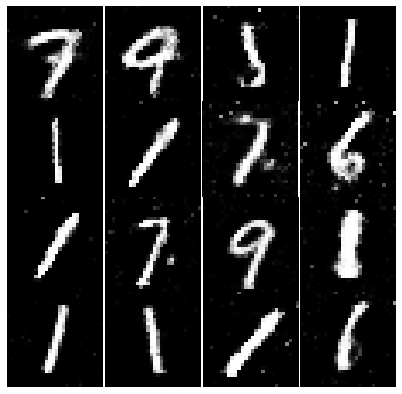

----------------------Epoch Number:135------------------------
Discriminator Loss:  0.8021188974380493 Generator Loss:  2.0419259071350098
Discriminator Loss:  0.8436998724937439 Generator Loss:  1.561012625694275
Discriminator Loss:  0.7118113040924072 Generator Loss:  1.830924153327942
Discriminator Loss:  0.6282974481582642 Generator Loss:  1.6706901788711548


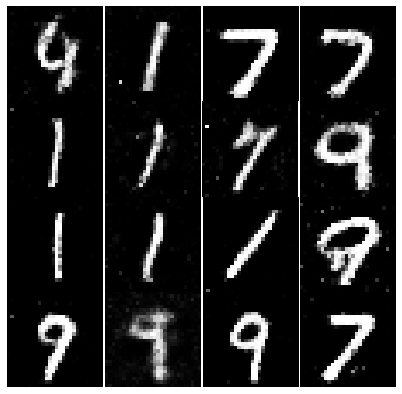

----------------------Epoch Number:136------------------------
Discriminator Loss:  0.7298918962478638 Generator Loss:  1.6632925271987915
Discriminator Loss:  0.606162965297699 Generator Loss:  1.9226064682006836
Discriminator Loss:  0.8396992683410645 Generator Loss:  1.7224931716918945
Discriminator Loss:  0.7338281273841858 Generator Loss:  1.901961088180542


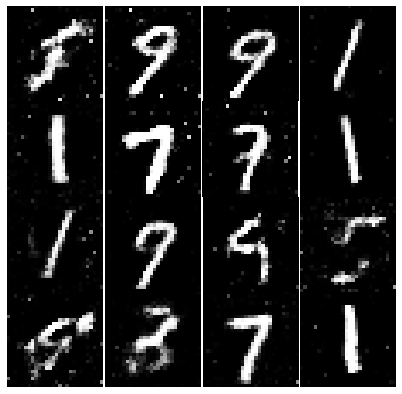

----------------------Epoch Number:137------------------------
Discriminator Loss:  0.7697634696960449 Generator Loss:  1.3988218307495117
Discriminator Loss:  0.8549503087997437 Generator Loss:  1.5280743837356567
Discriminator Loss:  0.6752975583076477 Generator Loss:  1.94711434841156
Discriminator Loss:  0.7536227107048035 Generator Loss:  1.692641019821167


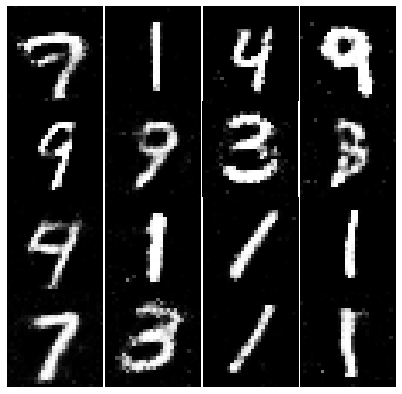

----------------------Epoch Number:138------------------------
Discriminator Loss:  0.6928595304489136 Generator Loss:  1.799270510673523
Discriminator Loss:  0.7630797028541565 Generator Loss:  1.475797414779663
Discriminator Loss:  0.6479198932647705 Generator Loss:  1.9936951398849487
Discriminator Loss:  0.8740130662918091 Generator Loss:  1.8677475452423096


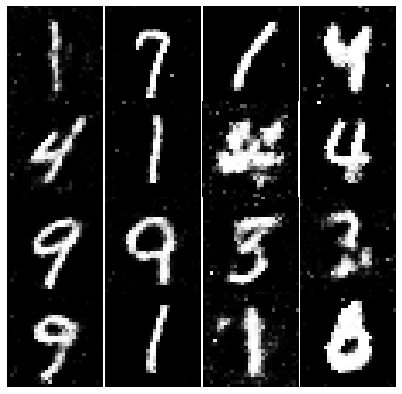

----------------------Epoch Number:139------------------------
Discriminator Loss:  0.794611394405365 Generator Loss:  1.679722785949707
Discriminator Loss:  0.8021119236946106 Generator Loss:  1.7089929580688477
Discriminator Loss:  0.8177928924560547 Generator Loss:  1.560248851776123
Discriminator Loss:  0.7562897205352783 Generator Loss:  1.872570514678955


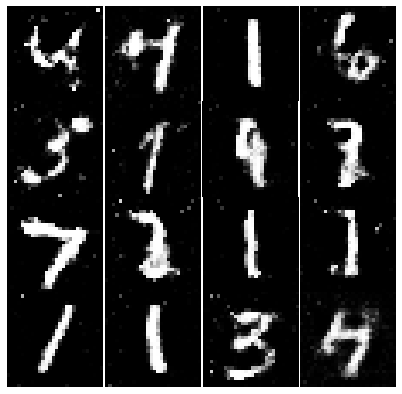

----------------------Epoch Number:140------------------------
Discriminator Loss:  0.6511694192886353 Generator Loss:  2.21638822555542
Discriminator Loss:  0.8346506953239441 Generator Loss:  1.5385477542877197
Discriminator Loss:  0.6201130747795105 Generator Loss:  1.9064483642578125
Discriminator Loss:  0.7163408398628235 Generator Loss:  1.6665611267089844


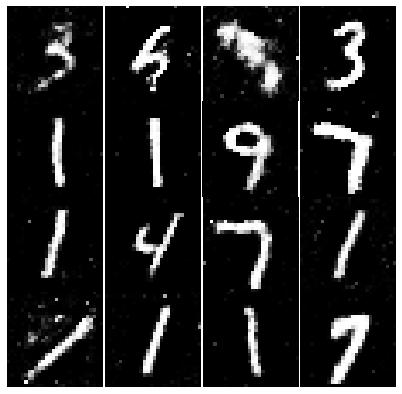

----------------------Epoch Number:141------------------------
Discriminator Loss:  0.5176680088043213 Generator Loss:  1.9110095500946045
Discriminator Loss:  0.6247819066047668 Generator Loss:  1.9658889770507812
Discriminator Loss:  0.633439302444458 Generator Loss:  1.7184154987335205
Discriminator Loss:  0.7214726805686951 Generator Loss:  1.651789665222168


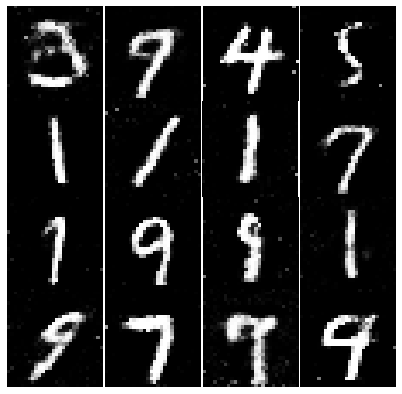

----------------------Epoch Number:142------------------------
Discriminator Loss:  0.6359337568283081 Generator Loss:  1.734266996383667
Discriminator Loss:  0.7601302862167358 Generator Loss:  2.434645414352417
Discriminator Loss:  0.7696832418441772 Generator Loss:  1.669628381729126
Discriminator Loss:  0.6997427940368652 Generator Loss:  2.0315351486206055


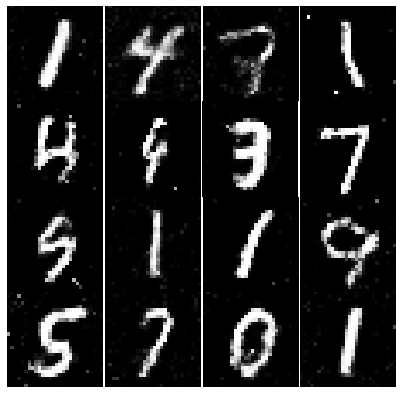

----------------------Epoch Number:143------------------------
Discriminator Loss:  0.7385448217391968 Generator Loss:  2.0890541076660156
Discriminator Loss:  0.6583470106124878 Generator Loss:  1.2957994937896729
Discriminator Loss:  0.6756137609481812 Generator Loss:  1.641316533088684
Discriminator Loss:  0.7481548190116882 Generator Loss:  2.184312582015991


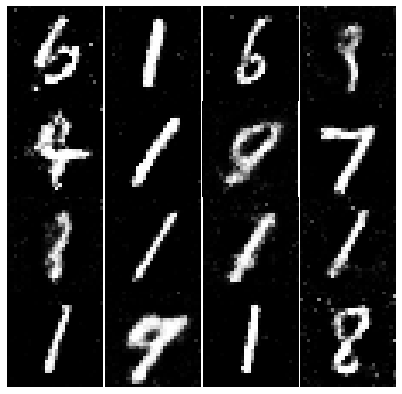

----------------------Epoch Number:144------------------------
Discriminator Loss:  0.7570334672927856 Generator Loss:  1.7234561443328857
Discriminator Loss:  0.8502835631370544 Generator Loss:  1.7111984491348267
Discriminator Loss:  0.8338683843612671 Generator Loss:  1.7327351570129395
Discriminator Loss:  0.8968854546546936 Generator Loss:  1.9941766262054443


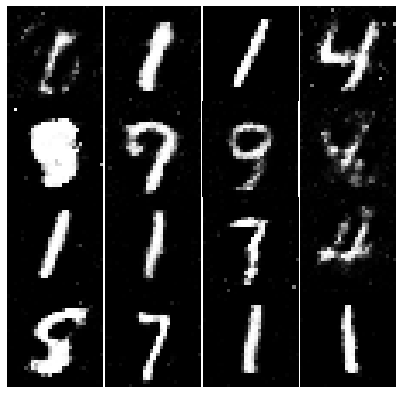

----------------------Epoch Number:145------------------------
Discriminator Loss:  0.8372671604156494 Generator Loss:  1.6857903003692627
Discriminator Loss:  0.673223614692688 Generator Loss:  1.9523680210113525
Discriminator Loss:  0.6879510283470154 Generator Loss:  2.275031566619873
Discriminator Loss:  0.7816939949989319 Generator Loss:  1.7344914674758911


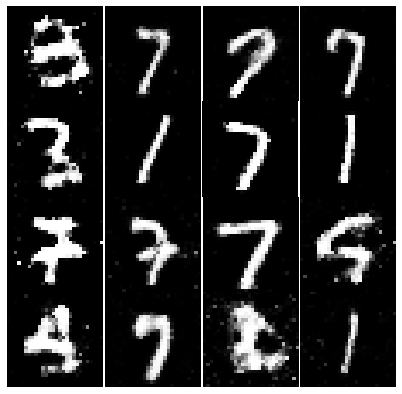

----------------------Epoch Number:146------------------------
Discriminator Loss:  0.867798924446106 Generator Loss:  1.6683932542800903
Discriminator Loss:  0.9652795791625977 Generator Loss:  1.483081340789795
Discriminator Loss:  1.0221304893493652 Generator Loss:  1.439644455909729
Discriminator Loss:  0.7900946140289307 Generator Loss:  1.5898211002349854


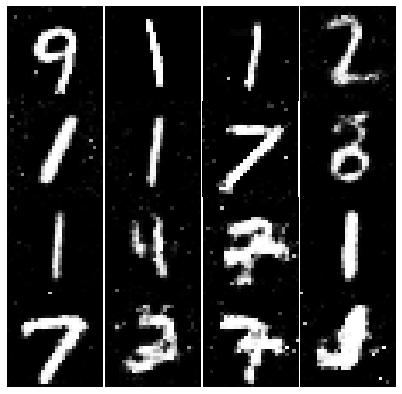

----------------------Epoch Number:147------------------------
Discriminator Loss:  0.7642788887023926 Generator Loss:  1.8804961442947388
Discriminator Loss:  0.7065833806991577 Generator Loss:  2.022663116455078
Discriminator Loss:  0.5416005849838257 Generator Loss:  2.14929461479187
Discriminator Loss:  0.7911872863769531 Generator Loss:  1.8599708080291748


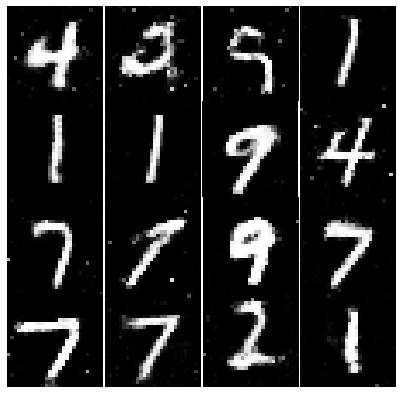

----------------------Epoch Number:148------------------------
Discriminator Loss:  0.8416273593902588 Generator Loss:  1.9366075992584229
Discriminator Loss:  0.7177607417106628 Generator Loss:  1.5226309299468994
Discriminator Loss:  0.9818755984306335 Generator Loss:  1.464213252067566
Discriminator Loss:  0.9443529844284058 Generator Loss:  1.1753946542739868


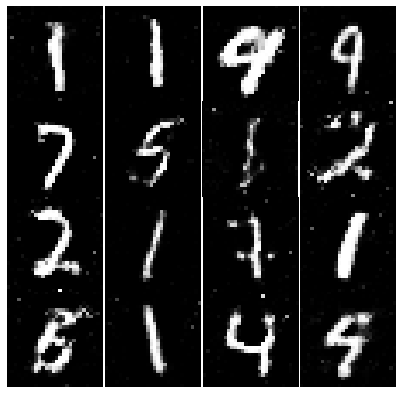

----------------------Epoch Number:149------------------------
Discriminator Loss:  0.7049790620803833 Generator Loss:  1.929599404335022
Discriminator Loss:  0.6736539602279663 Generator Loss:  1.6658828258514404
Discriminator Loss:  0.6973150968551636 Generator Loss:  1.4909119606018066
Discriminator Loss:  0.7507679462432861 Generator Loss:  1.6687268018722534


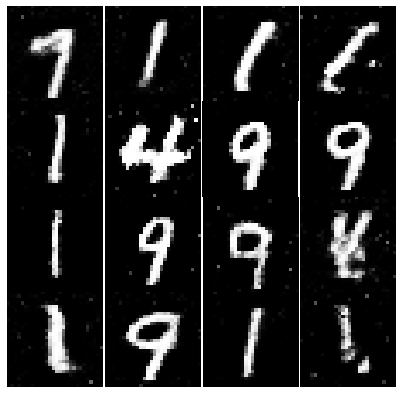

----------------------Epoch Number:150------------------------
Discriminator Loss:  0.7880995273590088 Generator Loss:  2.064469337463379
Discriminator Loss:  0.6057478785514832 Generator Loss:  1.8694783449172974
Discriminator Loss:  0.6955629587173462 Generator Loss:  1.7167490720748901
Discriminator Loss:  0.8553436398506165 Generator Loss:  1.3048760890960693


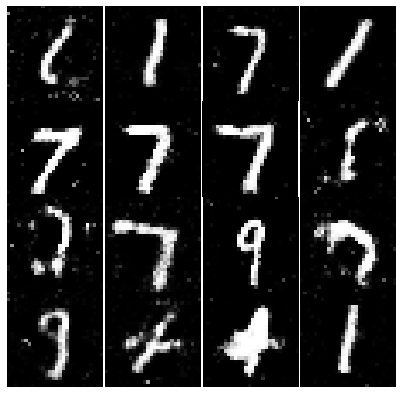

----------------------Epoch Number:151------------------------
Discriminator Loss:  0.833931565284729 Generator Loss:  1.3592848777770996
Discriminator Loss:  0.8629978895187378 Generator Loss:  1.8328675031661987
Discriminator Loss:  0.9666608572006226 Generator Loss:  1.5448975563049316
Discriminator Loss:  0.6867465376853943 Generator Loss:  1.953383207321167


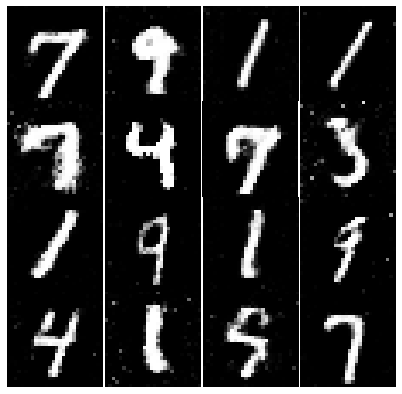

----------------------Epoch Number:152------------------------
Discriminator Loss:  0.7288473844528198 Generator Loss:  1.6439999341964722
Discriminator Loss:  0.7738189697265625 Generator Loss:  1.654642939567566
Discriminator Loss:  0.761443018913269 Generator Loss:  1.300716757774353
Discriminator Loss:  0.7213961482048035 Generator Loss:  1.7047938108444214


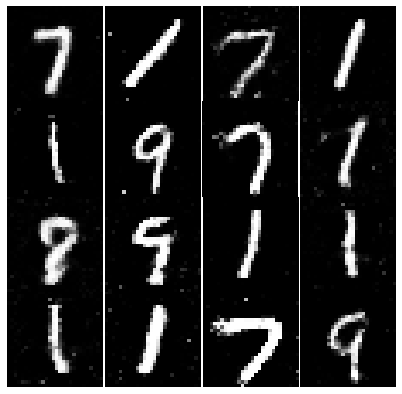

----------------------Epoch Number:153------------------------
Discriminator Loss:  0.7479629516601562 Generator Loss:  1.4348400831222534
Discriminator Loss:  0.7800398468971252 Generator Loss:  2.2379045486450195
Discriminator Loss:  0.74625164270401 Generator Loss:  1.3142327070236206
Discriminator Loss:  0.6999812722206116 Generator Loss:  1.4018640518188477


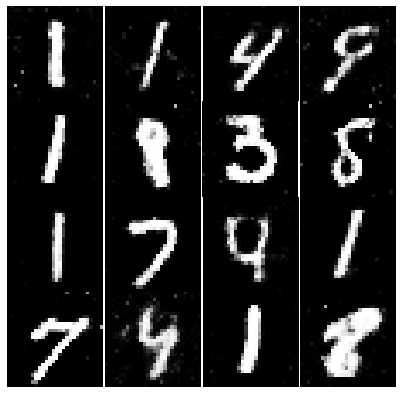

----------------------Epoch Number:154------------------------
Discriminator Loss:  0.847436249256134 Generator Loss:  1.4865977764129639
Discriminator Loss:  0.8991562128067017 Generator Loss:  1.5752837657928467
Discriminator Loss:  0.7513626217842102 Generator Loss:  1.792426586151123
Discriminator Loss:  0.8035114407539368 Generator Loss:  1.64830482006073


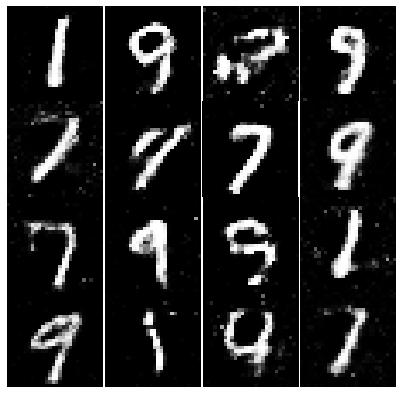

----------------------Epoch Number:155------------------------
Discriminator Loss:  0.7880207300186157 Generator Loss:  1.581444501876831
Discriminator Loss:  0.726080596446991 Generator Loss:  1.3583862781524658
Discriminator Loss:  0.688228964805603 Generator Loss:  2.2228779792785645
Discriminator Loss:  0.6116312146186829 Generator Loss:  1.6118621826171875


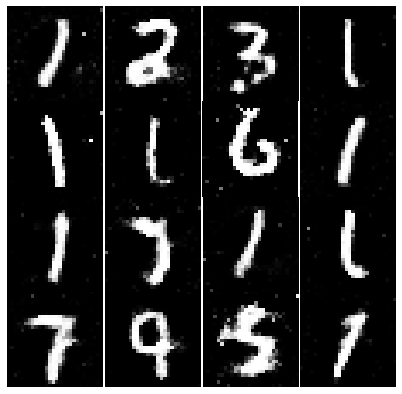

----------------------Epoch Number:156------------------------
Discriminator Loss:  0.7355605363845825 Generator Loss:  2.0831305980682373
Discriminator Loss:  0.8238080143928528 Generator Loss:  1.8192203044891357
Discriminator Loss:  0.8441317677497864 Generator Loss:  1.477872371673584
Discriminator Loss:  0.6040771007537842 Generator Loss:  1.5256630182266235


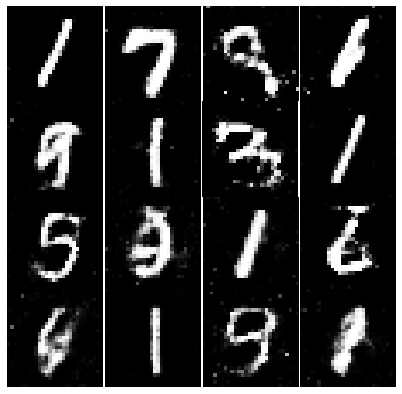

----------------------Epoch Number:157------------------------
Discriminator Loss:  0.6888635754585266 Generator Loss:  1.9509199857711792
Discriminator Loss:  0.9750211238861084 Generator Loss:  2.372750759124756
Discriminator Loss:  0.6894588470458984 Generator Loss:  1.7412736415863037
Discriminator Loss:  0.8538119196891785 Generator Loss:  1.6705436706542969


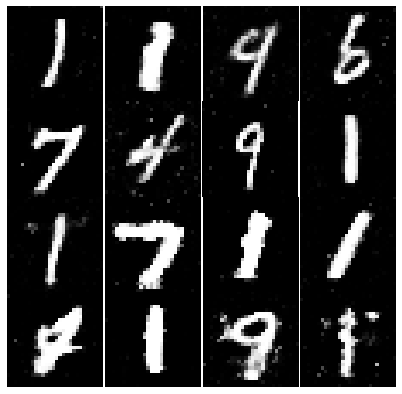

----------------------Epoch Number:158------------------------
Discriminator Loss:  0.7789307832717896 Generator Loss:  1.6380366086959839
Discriminator Loss:  0.7529088854789734 Generator Loss:  1.8425865173339844
Discriminator Loss:  0.619749128818512 Generator Loss:  1.6640722751617432
Discriminator Loss:  0.7444635033607483 Generator Loss:  1.8600895404815674


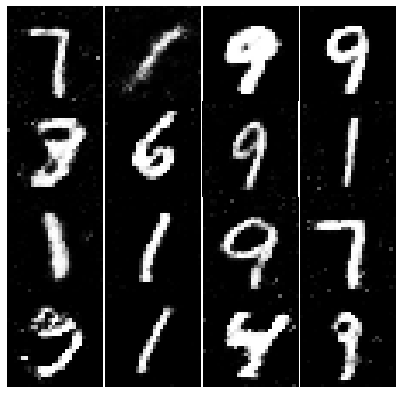

----------------------Epoch Number:159------------------------
Discriminator Loss:  0.7145411968231201 Generator Loss:  1.7132680416107178
Discriminator Loss:  0.6955831050872803 Generator Loss:  1.8440876007080078
Discriminator Loss:  0.6445705890655518 Generator Loss:  1.55774986743927
Discriminator Loss:  0.7379737496376038 Generator Loss:  1.88655424118042


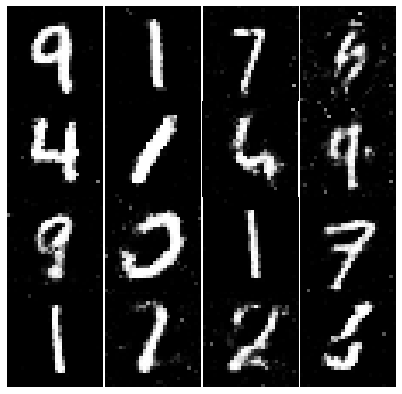

----------------------Epoch Number:160------------------------
Discriminator Loss:  0.707579493522644 Generator Loss:  1.8910443782806396
Discriminator Loss:  0.7005696296691895 Generator Loss:  1.6636130809783936
Discriminator Loss:  0.9014556407928467 Generator Loss:  1.6723601818084717
Discriminator Loss:  1.0228166580200195 Generator Loss:  2.0298566818237305


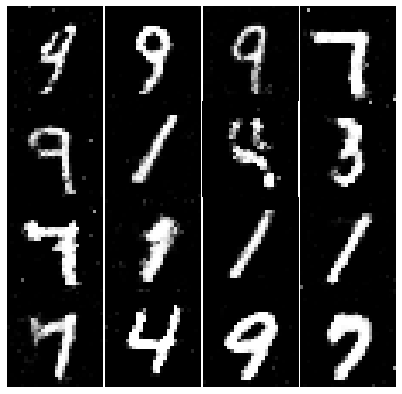

----------------------Epoch Number:161------------------------
Discriminator Loss:  0.7211763858795166 Generator Loss:  1.7424527406692505
Discriminator Loss:  0.7873667478561401 Generator Loss:  1.675138235092163
Discriminator Loss:  0.597596287727356 Generator Loss:  1.8223726749420166
Discriminator Loss:  0.6676453351974487 Generator Loss:  1.8043016195297241


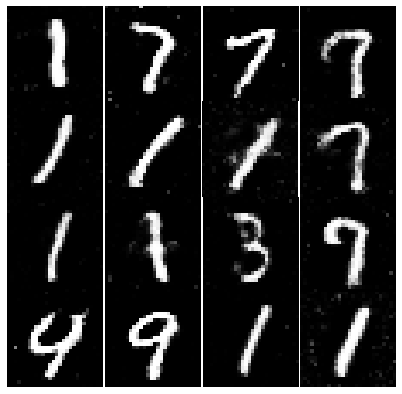

----------------------Epoch Number:162------------------------
Discriminator Loss:  0.7306274175643921 Generator Loss:  1.6916637420654297
Discriminator Loss:  0.8617280721664429 Generator Loss:  1.506716251373291
Discriminator Loss:  0.7403530478477478 Generator Loss:  1.6802102327346802
Discriminator Loss:  0.7380504608154297 Generator Loss:  1.6370497941970825


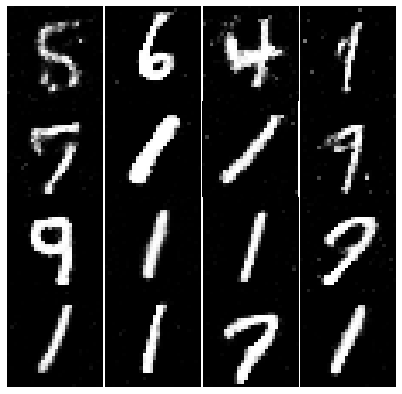

----------------------Epoch Number:163------------------------
Discriminator Loss:  0.8023004531860352 Generator Loss:  1.4721509218215942
Discriminator Loss:  0.7709476947784424 Generator Loss:  1.5819594860076904
Discriminator Loss:  0.5833098888397217 Generator Loss:  1.7435029745101929
Discriminator Loss:  0.7249579429626465 Generator Loss:  1.8413443565368652


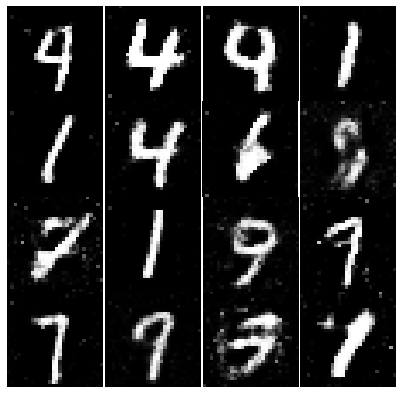

----------------------Epoch Number:164------------------------
Discriminator Loss:  0.759839653968811 Generator Loss:  1.716614842414856
Discriminator Loss:  0.8340879082679749 Generator Loss:  1.5176639556884766
Discriminator Loss:  0.6916767358779907 Generator Loss:  1.8985933065414429
Discriminator Loss:  0.8013147115707397 Generator Loss:  1.5796005725860596


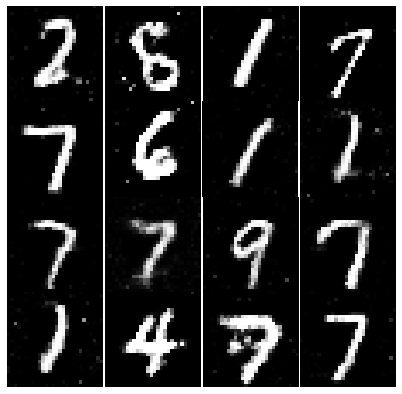

----------------------Epoch Number:165------------------------
Discriminator Loss:  0.6930953860282898 Generator Loss:  1.6431212425231934
Discriminator Loss:  0.7153779864311218 Generator Loss:  1.9723222255706787
Discriminator Loss:  0.736617386341095 Generator Loss:  2.52311372756958
Discriminator Loss:  0.6949019432067871 Generator Loss:  1.9150879383087158


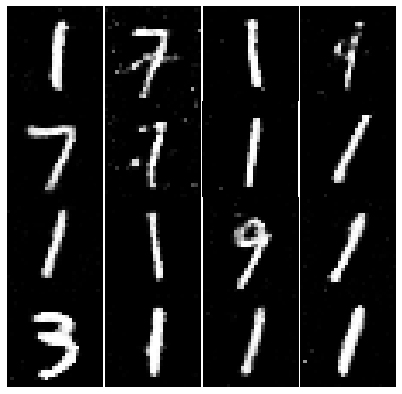

----------------------Epoch Number:166------------------------
Discriminator Loss:  0.7791266441345215 Generator Loss:  1.8962246179580688
Discriminator Loss:  0.7293404340744019 Generator Loss:  1.678603172302246
Discriminator Loss:  0.6193898916244507 Generator Loss:  1.6980669498443604
Discriminator Loss:  0.6635787487030029 Generator Loss:  2.137779712677002


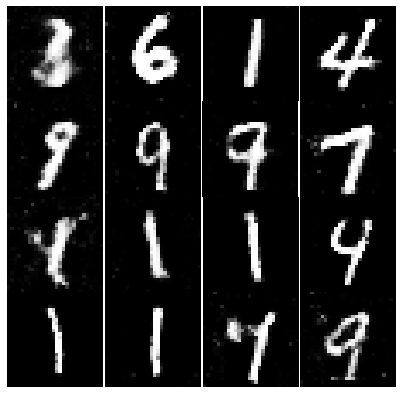

----------------------Epoch Number:167------------------------
Discriminator Loss:  0.7253084182739258 Generator Loss:  1.636364221572876
Discriminator Loss:  0.7557998895645142 Generator Loss:  1.5106946229934692
Discriminator Loss:  0.9902635812759399 Generator Loss:  1.595457911491394
Discriminator Loss:  0.6622804403305054 Generator Loss:  1.5073012113571167


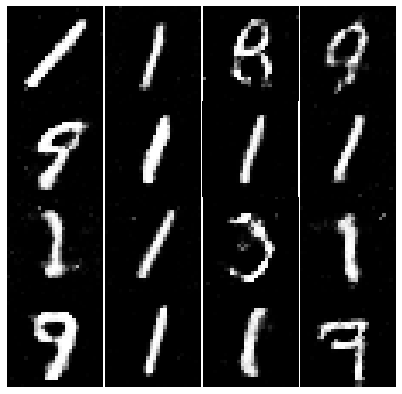

----------------------Epoch Number:168------------------------
Discriminator Loss:  0.7347217798233032 Generator Loss:  1.648695707321167
Discriminator Loss:  0.7081838846206665 Generator Loss:  1.8577282428741455
Discriminator Loss:  0.7918356657028198 Generator Loss:  1.5870440006256104
Discriminator Loss:  0.7262002229690552 Generator Loss:  2.118830680847168


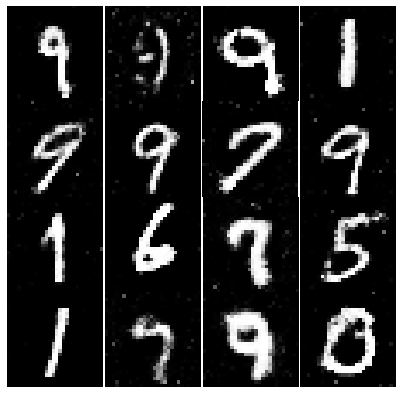

----------------------Epoch Number:169------------------------
Discriminator Loss:  0.6439189910888672 Generator Loss:  2.0329089164733887
Discriminator Loss:  0.7048891186714172 Generator Loss:  1.5193909406661987
Discriminator Loss:  0.7594566941261292 Generator Loss:  1.627347707748413
Discriminator Loss:  0.6763470768928528 Generator Loss:  1.7980451583862305


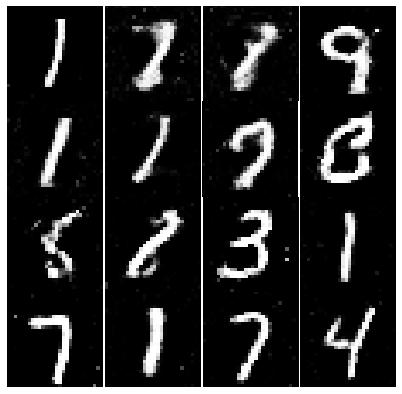

----------------------Epoch Number:170------------------------
Discriminator Loss:  0.7424352169036865 Generator Loss:  1.4727050065994263
Discriminator Loss:  0.8965706825256348 Generator Loss:  1.7239091396331787
Discriminator Loss:  0.8395941257476807 Generator Loss:  1.657690167427063
Discriminator Loss:  0.9835635423660278 Generator Loss:  1.6139819622039795


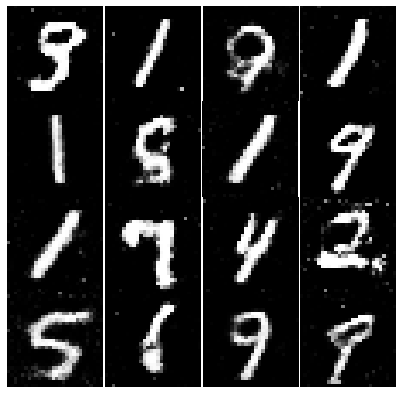

----------------------Epoch Number:171------------------------
Discriminator Loss:  0.9690464735031128 Generator Loss:  1.5000920295715332
Discriminator Loss:  0.9387762546539307 Generator Loss:  1.688126802444458
Discriminator Loss:  0.7786147594451904 Generator Loss:  1.8570164442062378
Discriminator Loss:  0.8365502953529358 Generator Loss:  1.9189635515213013


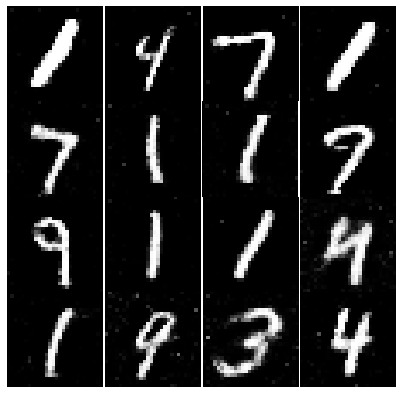

----------------------Epoch Number:172------------------------
Discriminator Loss:  0.8666008710861206 Generator Loss:  1.7915654182434082
Discriminator Loss:  0.5600898861885071 Generator Loss:  2.337207794189453
Discriminator Loss:  0.8281494379043579 Generator Loss:  1.5975580215454102
Discriminator Loss:  0.8468107581138611 Generator Loss:  1.8596372604370117


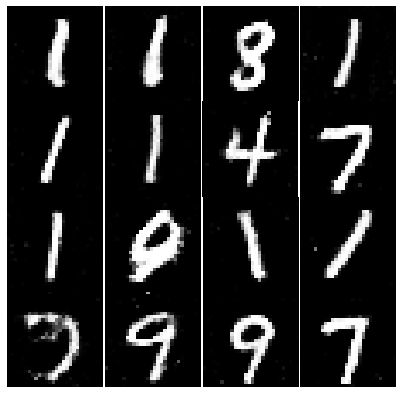

----------------------Epoch Number:173------------------------
Discriminator Loss:  0.7205843925476074 Generator Loss:  1.9308788776397705
Discriminator Loss:  0.7538741827011108 Generator Loss:  1.356316089630127
Discriminator Loss:  0.8283463716506958 Generator Loss:  1.7592021226882935
Discriminator Loss:  0.7402008771896362 Generator Loss:  2.002269744873047


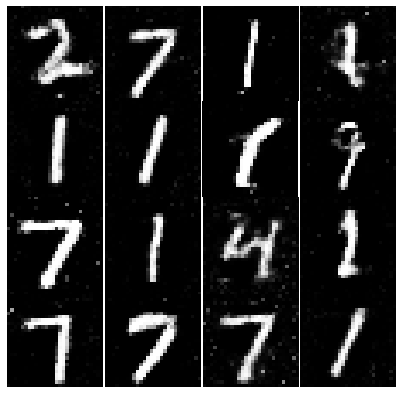

----------------------Epoch Number:174------------------------
Discriminator Loss:  0.6209713220596313 Generator Loss:  1.9955562353134155
Discriminator Loss:  0.8495681881904602 Generator Loss:  1.6170060634613037
Discriminator Loss:  0.9126371145248413 Generator Loss:  2.0683393478393555
Discriminator Loss:  0.5185497999191284 Generator Loss:  2.121389627456665


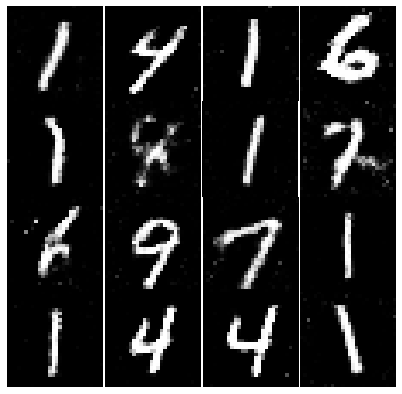

----------------------Epoch Number:175------------------------
Discriminator Loss:  0.7294206619262695 Generator Loss:  1.7501215934753418
Discriminator Loss:  1.0720603466033936 Generator Loss:  2.0190367698669434
Discriminator Loss:  0.6379284858703613 Generator Loss:  1.988501787185669
Discriminator Loss:  0.6795247793197632 Generator Loss:  1.3460490703582764


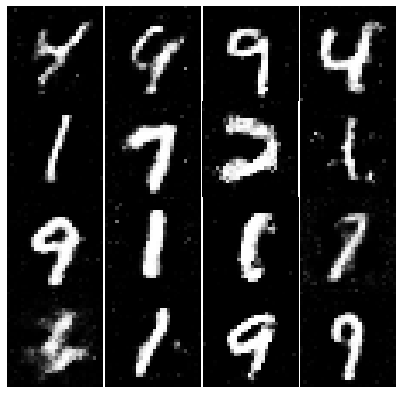

----------------------Epoch Number:176------------------------
Discriminator Loss:  0.6367660760879517 Generator Loss:  2.2890119552612305
Discriminator Loss:  0.6319257616996765 Generator Loss:  1.564569115638733
Discriminator Loss:  1.0246775150299072 Generator Loss:  1.4563312530517578
Discriminator Loss:  0.872972309589386 Generator Loss:  1.1300629377365112


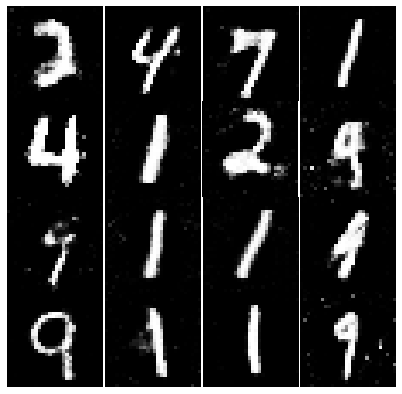

----------------------Epoch Number:177------------------------
Discriminator Loss:  0.6502431035041809 Generator Loss:  1.5402628183364868
Discriminator Loss:  0.6782960891723633 Generator Loss:  1.3887985944747925
Discriminator Loss:  0.7731891870498657 Generator Loss:  1.8425744771957397
Discriminator Loss:  0.7036354541778564 Generator Loss:  1.5353842973709106


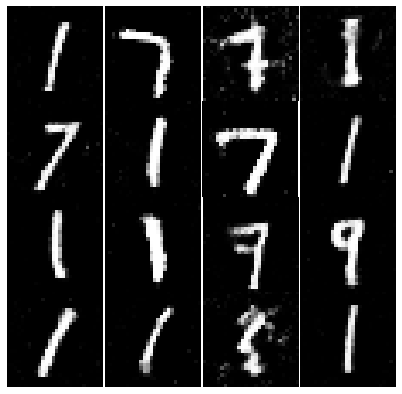

----------------------Epoch Number:178------------------------
Discriminator Loss:  0.712774395942688 Generator Loss:  1.842462420463562
Discriminator Loss:  0.8107028007507324 Generator Loss:  1.593252182006836
Discriminator Loss:  0.782448947429657 Generator Loss:  1.5914349555969238
Discriminator Loss:  0.8930850028991699 Generator Loss:  1.2475281953811646


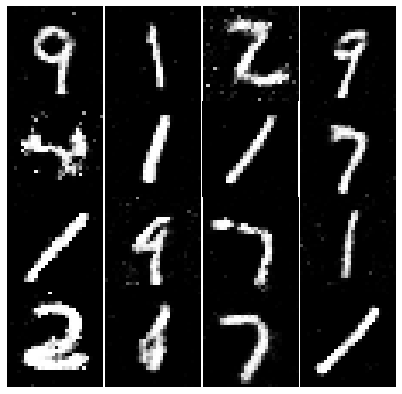

----------------------Epoch Number:179------------------------
Discriminator Loss:  0.8428072333335876 Generator Loss:  2.006638526916504
Discriminator Loss:  0.6880229711532593 Generator Loss:  1.4384547472000122
Discriminator Loss:  0.9239767789840698 Generator Loss:  1.431203842163086
Discriminator Loss:  0.8424326181411743 Generator Loss:  1.9526571035385132


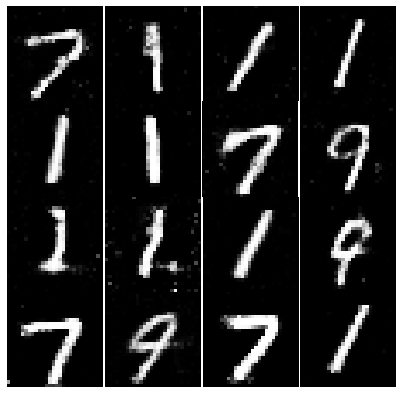

----------------------Epoch Number:180------------------------
Discriminator Loss:  0.6578347682952881 Generator Loss:  1.5686206817626953
Discriminator Loss:  0.6982877850532532 Generator Loss:  1.6397162675857544
Discriminator Loss:  0.7519264221191406 Generator Loss:  1.8934261798858643
Discriminator Loss:  0.8356107473373413 Generator Loss:  1.5610766410827637


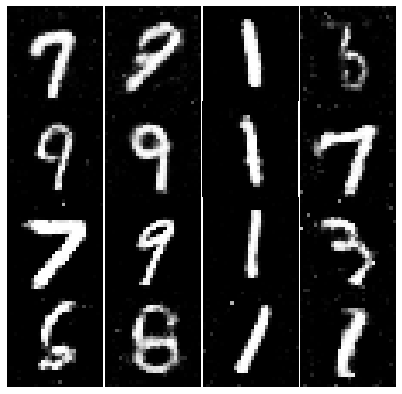

----------------------Epoch Number:181------------------------
Discriminator Loss:  0.5933475494384766 Generator Loss:  1.6333037614822388
Discriminator Loss:  0.8484966158866882 Generator Loss:  1.7485630512237549
Discriminator Loss:  0.6302515268325806 Generator Loss:  1.564812421798706
Discriminator Loss:  0.9271612167358398 Generator Loss:  1.9065003395080566


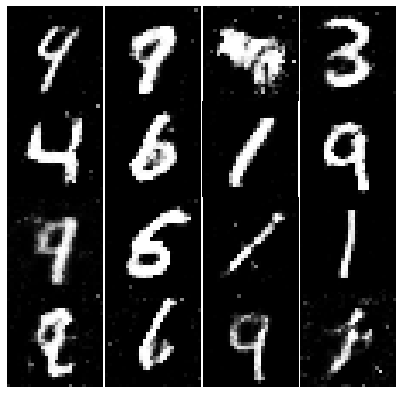

----------------------Epoch Number:182------------------------
Discriminator Loss:  0.9637759327888489 Generator Loss:  1.6383850574493408
Discriminator Loss:  0.6840965747833252 Generator Loss:  1.8027043342590332
Discriminator Loss:  0.9481456875801086 Generator Loss:  1.7296833992004395
Discriminator Loss:  0.6873010396957397 Generator Loss:  1.6004011631011963


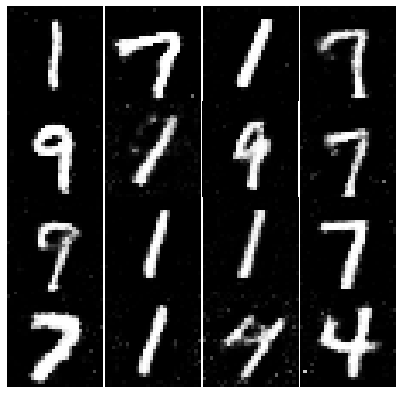

----------------------Epoch Number:183------------------------
Discriminator Loss:  0.682938814163208 Generator Loss:  1.5767825841903687
Discriminator Loss:  0.864166796207428 Generator Loss:  1.9007422924041748
Discriminator Loss:  0.7214694023132324 Generator Loss:  1.8209503889083862
Discriminator Loss:  0.8521196842193604 Generator Loss:  1.4566981792449951


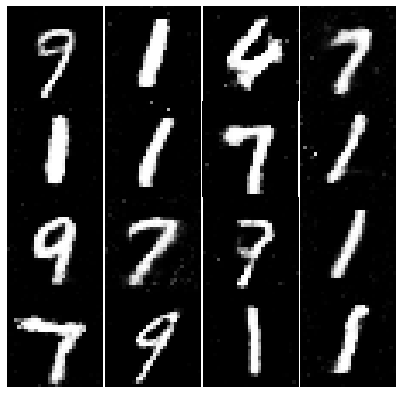

----------------------Epoch Number:184------------------------
Discriminator Loss:  0.7349532842636108 Generator Loss:  1.499250888824463
Discriminator Loss:  0.9027047753334045 Generator Loss:  1.512253761291504
Discriminator Loss:  0.7429395318031311 Generator Loss:  1.206578254699707
Discriminator Loss:  0.710511326789856 Generator Loss:  1.5642948150634766


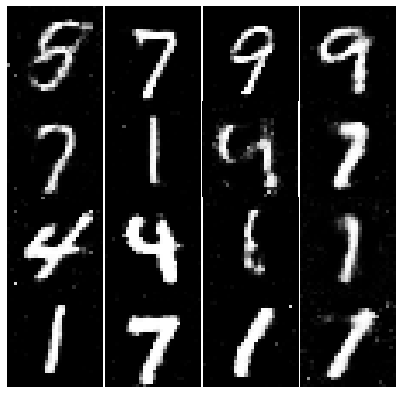

----------------------Epoch Number:185------------------------
Discriminator Loss:  0.6509390473365784 Generator Loss:  1.9389289617538452
Discriminator Loss:  0.8330525755882263 Generator Loss:  1.290043830871582
Discriminator Loss:  0.6785414218902588 Generator Loss:  1.9962407350540161
Discriminator Loss:  0.8257081508636475 Generator Loss:  1.5048091411590576


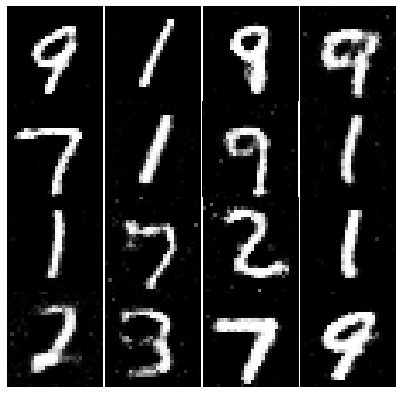

----------------------Epoch Number:186------------------------
Discriminator Loss:  0.8887360692024231 Generator Loss:  1.2568771839141846
Discriminator Loss:  0.7436100244522095 Generator Loss:  1.8633569478988647
Discriminator Loss:  0.7946393489837646 Generator Loss:  1.7346400022506714
Discriminator Loss:  0.7990411520004272 Generator Loss:  1.6691639423370361


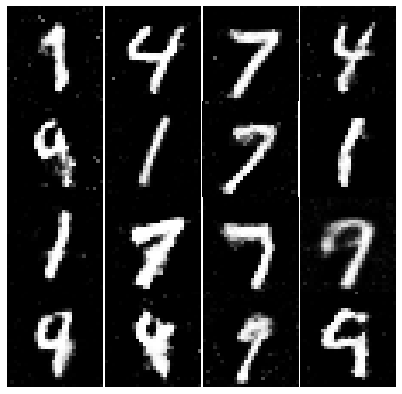

----------------------Epoch Number:187------------------------
Discriminator Loss:  0.7921572923660278 Generator Loss:  1.6491132974624634
Discriminator Loss:  0.9487823247909546 Generator Loss:  1.4434171915054321
Discriminator Loss:  0.8601943254470825 Generator Loss:  1.952179193496704
Discriminator Loss:  0.5824704766273499 Generator Loss:  1.8246734142303467


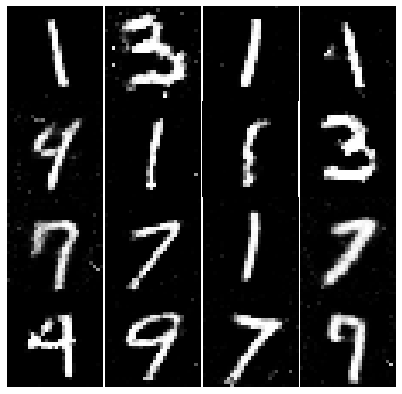

----------------------Epoch Number:188------------------------
Discriminator Loss:  0.8907231092453003 Generator Loss:  1.5723620653152466
Discriminator Loss:  0.9530733823776245 Generator Loss:  1.7159379720687866
Discriminator Loss:  0.6951761841773987 Generator Loss:  1.5641884803771973
Discriminator Loss:  0.864649772644043 Generator Loss:  1.4799110889434814


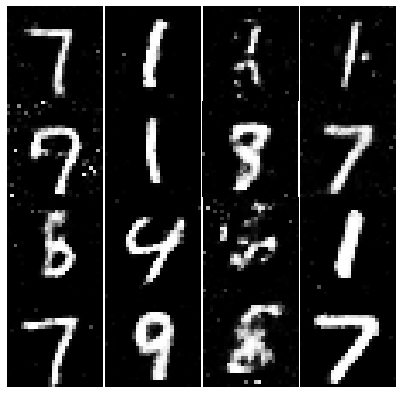

----------------------Epoch Number:189------------------------
Discriminator Loss:  0.6428462266921997 Generator Loss:  1.783547043800354
Discriminator Loss:  0.8265343308448792 Generator Loss:  1.6375946998596191
Discriminator Loss:  0.8341237306594849 Generator Loss:  1.4523942470550537
Discriminator Loss:  0.7386147379875183 Generator Loss:  1.9492768049240112


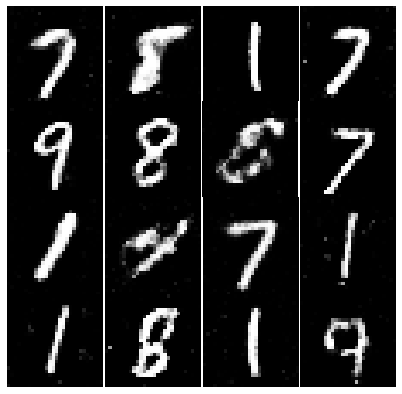

----------------------Epoch Number:190------------------------
Discriminator Loss:  0.8739229440689087 Generator Loss:  1.771348237991333
Discriminator Loss:  0.6811785697937012 Generator Loss:  1.6386977434158325
Discriminator Loss:  0.7848666310310364 Generator Loss:  1.8287516832351685
Discriminator Loss:  0.8192660808563232 Generator Loss:  1.8856302499771118


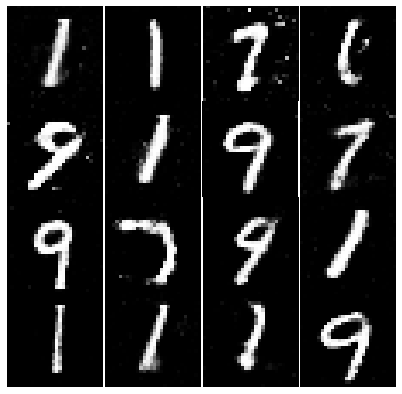

----------------------Epoch Number:191------------------------
Discriminator Loss:  0.6029565930366516 Generator Loss:  1.5583038330078125
Discriminator Loss:  0.7358006238937378 Generator Loss:  1.5519816875457764
Discriminator Loss:  0.830474853515625 Generator Loss:  1.6021610498428345
Discriminator Loss:  0.7518569827079773 Generator Loss:  2.0798845291137695


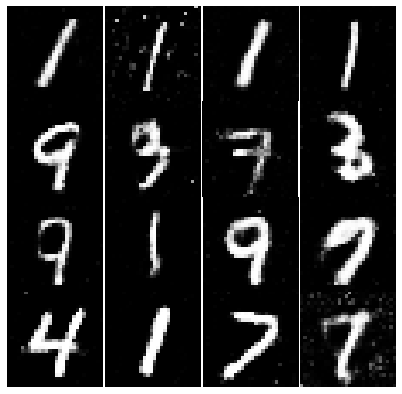

----------------------Epoch Number:192------------------------
Discriminator Loss:  0.5849153995513916 Generator Loss:  1.8063976764678955
Discriminator Loss:  0.8984343409538269 Generator Loss:  1.857203722000122
Discriminator Loss:  0.7121371030807495 Generator Loss:  1.7475844621658325
Discriminator Loss:  0.7618938684463501 Generator Loss:  1.621320366859436


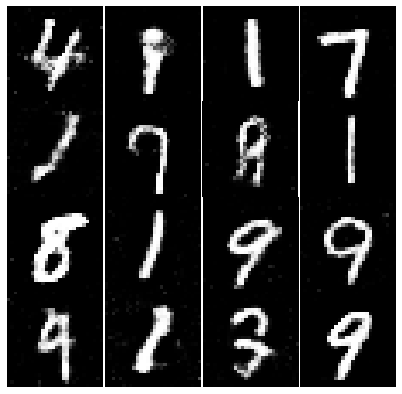

----------------------Epoch Number:193------------------------
Discriminator Loss:  0.882652997970581 Generator Loss:  1.4082400798797607
Discriminator Loss:  0.710269570350647 Generator Loss:  1.8602449893951416
Discriminator Loss:  0.6675971746444702 Generator Loss:  1.9384074211120605
Discriminator Loss:  0.7653464078903198 Generator Loss:  1.509648323059082


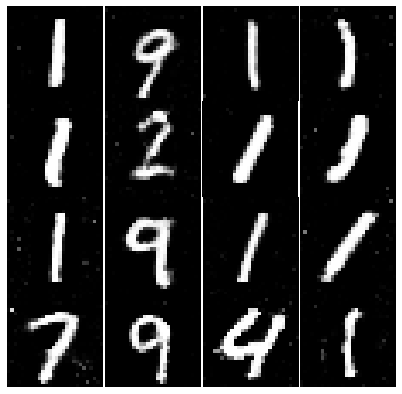

----------------------Epoch Number:194------------------------
Discriminator Loss:  0.6694744825363159 Generator Loss:  1.7696985006332397
Discriminator Loss:  0.5687453746795654 Generator Loss:  1.6040562391281128
Discriminator Loss:  0.9006649255752563 Generator Loss:  1.124537706375122
Discriminator Loss:  0.6185799837112427 Generator Loss:  1.8941912651062012


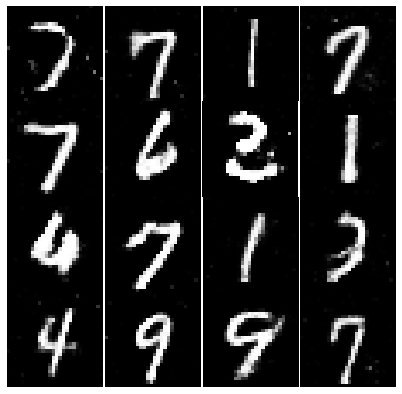

----------------------Epoch Number:195------------------------
Discriminator Loss:  0.6927908658981323 Generator Loss:  1.7733614444732666
Discriminator Loss:  0.832688570022583 Generator Loss:  1.3751994371414185
Discriminator Loss:  0.6844340562820435 Generator Loss:  1.8772037029266357
Discriminator Loss:  0.7800623178482056 Generator Loss:  1.5361323356628418


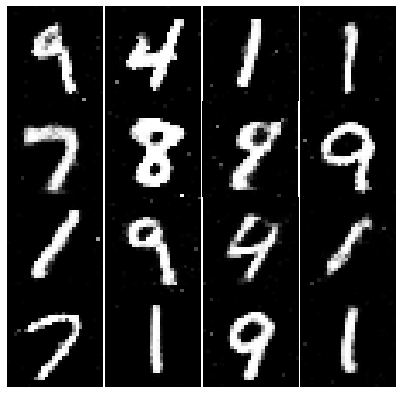

----------------------Epoch Number:196------------------------
Discriminator Loss:  0.7161911725997925 Generator Loss:  1.6741878986358643
Discriminator Loss:  0.6500282287597656 Generator Loss:  2.086052179336548
Discriminator Loss:  0.6304470300674438 Generator Loss:  1.5201895236968994
Discriminator Loss:  0.8794155120849609 Generator Loss:  1.6815129518508911


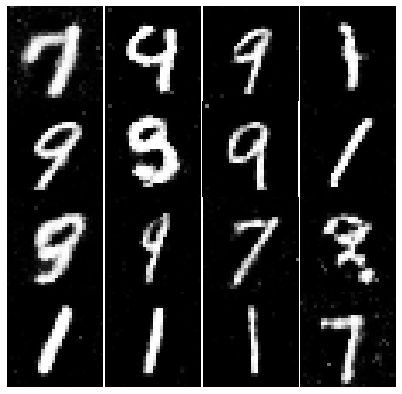

----------------------Epoch Number:197------------------------
Discriminator Loss:  0.657704770565033 Generator Loss:  1.705765724182129
Discriminator Loss:  0.7464244365692139 Generator Loss:  1.8373504877090454
Discriminator Loss:  0.6564802527427673 Generator Loss:  1.75835382938385
Discriminator Loss:  0.5271735191345215 Generator Loss:  1.923158884048462


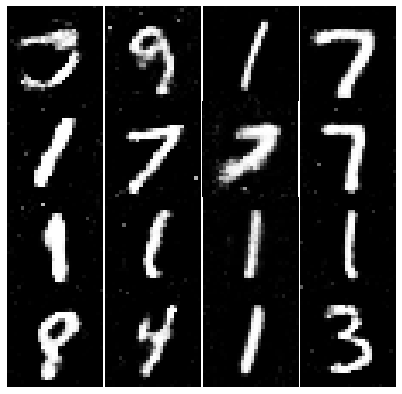

----------------------Epoch Number:198------------------------
Discriminator Loss:  0.7045941352844238 Generator Loss:  1.6358208656311035
Discriminator Loss:  0.7617000341415405 Generator Loss:  1.935375452041626
Discriminator Loss:  0.8600694537162781 Generator Loss:  1.6254866123199463
Discriminator Loss:  0.6118038892745972 Generator Loss:  1.647745966911316


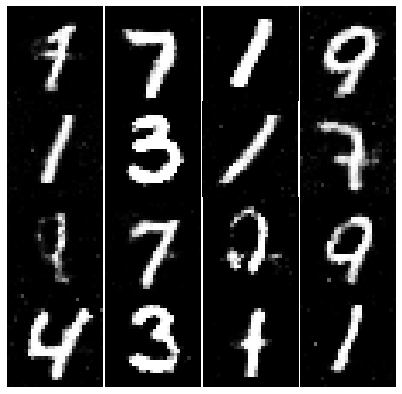

----------------------Epoch Number:199------------------------
Discriminator Loss:  0.7556346654891968 Generator Loss:  1.7477173805236816
Discriminator Loss:  0.6555267572402954 Generator Loss:  1.6374341249465942
Discriminator Loss:  0.8693815469741821 Generator Loss:  1.3805184364318848
Discriminator Loss:  0.5777847766876221 Generator Loss:  2.032057046890259


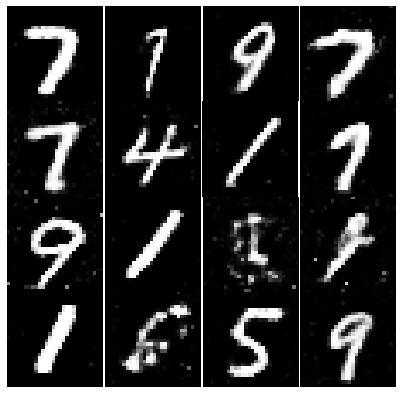

----------------------Epoch Number:200------------------------
Discriminator Loss:  0.6192420125007629 Generator Loss:  1.4565634727478027
Discriminator Loss:  1.012099266052246 Generator Loss:  1.6362864971160889
Discriminator Loss:  0.7256394624710083 Generator Loss:  2.0642547607421875
Discriminator Loss:  0.8318039774894714 Generator Loss:  1.5526175498962402


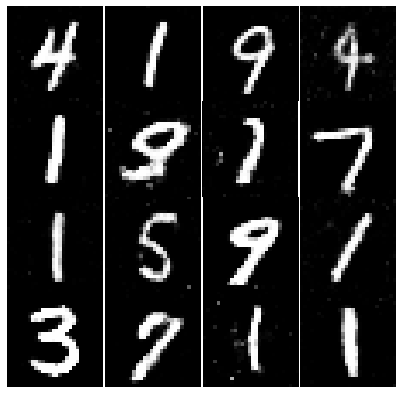

In [16]:
#Let's train for 200 epochs
train_gan(200)

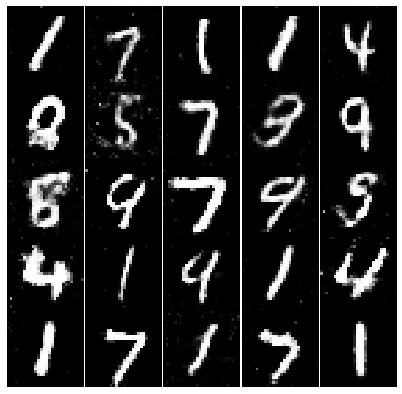

In [25]:
#Lets check final results
inspect(5)